# Read dataset 
imageio package is used for read tiff picture
seaborn package is a advanced matplotlib package fgsearchor figure

In [3]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
import imageio #这个东西是用来读取tiff图片得
import seaborn as sns
import time   #时间相关的

plt.style.use('classic')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
path = os.path.abspath(os.path.dirname(os.getcwd()) + os.path.sep + ".")
raw_data_point = path+'\LSM\PointData'     #这个是用来读取点数据路径得
raw_data_raster = path+'\LSM\RasterData2'   #这个是用来读取像素数据得
Picture_result = path+'\LSM\Picture'   #这个是用来读取像素数据得


#本处为载入将要运用的全部模型
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import LinearSVC

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.metrics import accuracy_score,mean_squared_error,roc_auc_score,roc_curve

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 随机种子42     5折训练
SEED = 42 
NFOLDS = 5
KF = KFold(n_splits= NFOLDS,shuffle=True,random_state=SEED)

## Model Load

In [4]:
All_dataPx1 = pd.read_csv('Raster10m.csv',encoding='utf-8',delimiter=',')
print('(Po1) No HLS samples:',All_dataPx1['A0'].value_counts()[0],'HLS samples:',All_dataPx1['A0'].value_counts()[1])
print('(Po1) No ELS samples:',All_dataPx1['A1'].value_counts()[0],'ELS samples:',All_dataPx1['A1'].value_counts()[1])
print('Raw shape of Px1 is',len(All_dataPx1))
del All_dataPx1

(Po1) No HLS samples: 9763022 HLS samples: 679479
(Po1) No ELS samples: 10078252 ELS samples: 364249
Raw shape of Px1 is 10442501


In [5]:
All_dataPo1 = pd.read_csv(raw_data_point + '\Point1.txt',encoding='ascii',delimiter=',')
All_dataPo1.replace(-9999,np.nan,inplace=True)
All_dataPo1.dropna(axis=0, how='any', inplace=True)
All_dataPo1.replace({'A0': 1, 'A1': 1}, 0,inplace=True)
All_dataPo1.replace({'A0': 2, 'A1': 2}, 1,inplace=True) 

In [6]:
PointReadtarget = ['\Point1.txt','\Point2.txt','\Point3.txt']
PointDataName = ['All_dataPo1','All_dataPo2','All_dataPo3']
All_data = pd.read_csv('Raster10m.csv',encoding='utf-8',delimiter=',')
for i,name in enumerate(PointDataName):
    globals()[name] = pd.read_csv(raw_data_point+PointReadtarget[i],encoding='ascii',delimiter=',')
    globals()[name].replace(-9999,np.nan,inplace=True)
    old_length = len(globals()[name])
    globals()[name].dropna(axis=0, how='any', inplace=True)
    new_length = len(globals()[name])
    print('Raw shape of Dataset',name,'is',old_length,'New:',new_length,'delete',old_length-new_length,'rows')
    globals()[name].replace({'A0': 1, 'A1': 1}, 0,inplace=True)
    globals()[name].replace({'A0': 2, 'A1': 2}, 1,inplace=True) 
    print(name,': No HLS samples:',globals()[name]['A0'].value_counts()[0],'HLS samples:',globals()[name]['A0'].value_counts()[1])
    print(name,': No HLS samples:',globals()[name]['A1'].value_counts()[0],'HLS samples:',globals()[name]['A1'].value_counts()[1])
    print("-------------------------------------------------------")

Raw shape of Dataset All_dataPo1 is 500000 New: 493443 delete 6557 rows
All_dataPo1 : No HLS samples: 463091 HLS samples: 30352
All_dataPo1 : No HLS samples: 477034 HLS samples: 16409
-------------------------------------------------------
Raw shape of Dataset All_dataPo2 is 121534 New: 120565 delete 969 rows
All_dataPo2 : No HLS samples: 82925 HLS samples: 37640
All_dataPo2 : No HLS samples: 98783 HLS samples: 21782
-------------------------------------------------------
Raw shape of Dataset All_dataPo3 is 16162 New: 16043 delete 119 rows
All_dataPo3 : No HLS samples: 14007 HLS samples: 2036
All_dataPo3 : No HLS samples: 9869 HLS samples: 6174
-------------------------------------------------------


# Model training speed test

## Model loading area

In [7]:
# 用来减少内存使用的方程
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum()  / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))  
    for col in df.columns:
        col_type = df[col].dtype    
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum()  / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
All_data = reduce_mem_usage(All_data)

Memory usage of dataframe is 1752.74 MB
Memory usage after optimization is: 408.31 MB
Decreased by 76.7%


## Minimum and maximum process (0.1-0.9)

In [9]:
LSM_Y =['A0']
LSM_X = ['A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12']
ESM_Y = ['A1']
ESM_X = ['A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A13','A14','A15','A16','A17','A18','A19','A20']

y_hls =  All_data[LSM_Y] ; y_hlsp1 = All_dataPo1[LSM_Y] ; y_hlsp2 = All_dataPo2[LSM_Y] ; y_hlsp3 = All_dataPo3[LSM_Y]
x_hls =  All_data[LSM_X] ; x_hlsp1 = All_dataPo1[LSM_X] ; x_hlsp2 = All_dataPo2[LSM_X] ; x_hlsp3 = All_dataPo3[LSM_X]
y_els =  All_data[ESM_Y] ; y_elsp1 = All_dataPo1[ESM_Y] ; y_elsp2 = All_dataPo2[ESM_Y] ; y_elsp3 = All_dataPo3[ESM_Y]
x_els =  All_data[ESM_X] ; x_elsp1 = All_dataPo1[ESM_X] ; x_elsp2 = All_dataPo2[ESM_X] ; x_elsp3 = All_dataPo3[ESM_X]

In [10]:
# 对输入模型进行标准化转化
from sklearn.preprocessing import StandardScaler,MinMaxScaler
print("-----------------------before the preprocessing--------------------------------")
Max_Sca = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_hls).data_max_
print('The maximun of each columns',Max_Sca)
Min_Sca = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_hls).data_min_
print('The minimun of each columns',Min_Sca)


print("-----------------------After the preprocessing--------------------------------")
column_index = x_hls.columns
x_hls_values = MinMaxScaler(feature_range=(0.1,0.9)).fit_transform(x_hls.values)
x_hls =pd.DataFrame(x_hls_values, columns = column_index) 


Max_Sca_after = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_hls).data_max_
print('The maximun of each columns',Max_Sca_after)
Min_Sca_after = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_hls).data_min_
print('The minimun of each columns',Min_Sca_after)

print("-----------------------preprocessing  Pointdata--------------------------------")

for i, column_name in enumerate(LSM_X):
    x_hlsp1[column_name] = x_hlsp1[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    x_hlsp2[column_name] = x_hlsp2[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    x_hlsp3[column_name] = x_hlsp3[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    print('Factor :',column_name,'Finished')

-----------------------before the preprocessing--------------------------------
The maximun of each columns [   20.     17.     12.   1002.5    72.2   360.     54.2 10730.   9000.
  1746.   1308. ]
The minimun of each columns [ 1.00e+00  1.00e+00  1.00e+00  0.00e+00  0.00e+00 -1.00e+00 -6.44e+01
  0.00e+00  0.00e+00  0.00e+00  1.07e+03]
-----------------------After the preprocessing--------------------------------
The maximun of each columns [0.9    0.8994 0.8994 0.9    0.9    0.9    0.8994 0.9    0.9    0.9
 0.8984]
The minimun of each columns [0.1    0.1    0.1    0.1    0.1    0.1    0.1001 0.1    0.1    0.1
 0.0996]
-----------------------preprocessing  Pointdata--------------------------------
Factor : A2 Finished
Factor : A3 Finished
Factor : A4 Finished
Factor : A5 Finished
Factor : A6 Finished
Factor : A7 Finished
Factor : A8 Finished
Factor : A9 Finished
Factor : A10 Finished
Factor : A11 Finished
Factor : A12 Finished


In [11]:
# 对输入模型进行标准化转化
from sklearn.preprocessing import StandardScaler,MinMaxScaler
print("-----------------------before the preprocessing--------------------------------")
Max_Sca = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_els).data_max_
print('The maximun of each columns',Max_Sca)
Min_Sca = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_els).data_min_
print('The minimun of each columns',Min_Sca)


print("-----------------------After the preprocessing--------------------------------")
column_index = x_els.columns
x_els_values = MinMaxScaler(feature_range=(0.1,0.9)).fit_transform(x_els.values)
x_els =pd.DataFrame(x_els_values, columns = column_index) 


Max_Sca_after = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_els).data_max_
print('The maximun of each columns',Max_Sca_after)
Min_Sca_after = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_els).data_min_
print('The minimun of each columns',Min_Sca_after)

print("-----------------------preprocessing  Pointdata--------------------------------")

for i, column_name in enumerate(ESM_X):
    x_elsp1[column_name] = x_elsp1[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    x_elsp2[column_name] = x_elsp2[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    x_elsp3[column_name] = x_elsp3[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    print('Factor :',column_name,'Finished')

-----------------------before the preprocessing--------------------------------
The maximun of each columns [2.0000000e+01 1.7000000e+01 1.2000000e+01 1.0025000e+03 7.2187500e+01
 3.6000000e+02 5.4187500e+01 1.0728000e+04 9.0000000e+03 1.7460000e+03
 3.3250000e+02 6.5500000e+02 8.1400000e+02 8.6200000e+02 1.3560000e+03
 6.3554688e+00 3.9296000e+04 3.6000000e+02]
The minimun of each columns [  1.         1.         1.         0.         0.        -1.
 -64.375      0.         0.         0.       217.125    123.5625
 106.        50.375    138.125      4.234375   0.         0.      ]
-----------------------After the preprocessing--------------------------------
The maximun of each columns [0.9        0.90000004 0.9        0.90000004 0.90000004 0.9
 0.90000004 0.90000004 0.90000004 0.90000004 0.9000001  0.90000004
 0.90000004 0.90000004 0.90000004 0.9000001  0.90000004 0.90000004]
The minimun of each columns [0.1        0.1        0.1        0.1        0.1        0.1
 0.09999999 0.1        

## Basic speed test in LR model

In [12]:
def get_oof(clf, X_Train, y_Train, X_Test):
    oof_train = np.zeros((len(X_Train),))
    oof_test = np.zeros((len(X_Test),))
    oof_test_skf = np.empty((NFOLDS, len(X_Test)))
    X_Train.index = range(len(X_Train))
    y_Train.index = range(len(y_Train))
    for i, (train_index, test_index) in enumerate(KF.split(X_Train)):
        X_tr = X_Train.loc[train_index]
        y_tr = y_Train.loc[train_index]
        X_te = X_Train.loc[test_index]

        clf.fit(X_tr, y_tr)

        oof_train[test_index] = clf.predict_proba(X_te)[:,1]
        oof_test_skf[i, :] = clf.predict_proba(X_Test)[:,1]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [13]:
%time lr_oof_train, lr_oof_test  = get_oof(LogisticRegression(), x_hls, y_hls, x_hls)
print("lr single AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_train))
print("lr test AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_test))

%time lr_oof_trainp1, lr_oof_testp1  = get_oof(LogisticRegression(), x_hlsp1, y_hlsp1, x_hls)
print("lr single AUC score: %.4f" % roc_auc_score(y_hlsp1,lr_oof_trainp1))
print("lr single AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_testp1))

%time lr_oof_trainp2, lr_oof_testp2  = get_oof(LogisticRegression(), x_hlsp2, y_hlsp2, x_hls)
print("lr single AUC score: %.4f" % roc_auc_score(y_hlsp2,lr_oof_trainp2))
print("lr single AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_testp2))

%time lr_oof_trainp3, lr_oof_testp3  = get_oof(LogisticRegression(), x_hlsp3, y_hlsp3, x_hls)
print("lr single AUC score: %.4f" % roc_auc_score(y_hlsp3,lr_oof_trainp3))
print("lr single AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_testp3))      

Wall time: 2min 46s
lr single AUC score: 0.8690
lr test AUC score: 0.8690
Wall time: 18.5 s
lr single AUC score: 0.8785
lr single AUC score: 0.8670
Wall time: 7.16 s
lr single AUC score: 0.8880
lr single AUC score: 0.8664
Wall time: 4.26 s
lr single AUC score: 0.8455
lr single AUC score: 0.8575


In [ ]:
KNN_Para1 = {'weights': 'uniform', 
             'algorithm': 'auto', 
             'metric': 'minkowski', 
             'n_neighbors': 10}

%time lr_oof_train, lr_oof_test  = get_oof(KNeighborsClassifier(**KNN_Para1), x_hls, y_hls, x_hls)
print("knn single AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_train))
print("knn test AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_test))

%time lr_oof_trainp1, lr_oof_testp1  = get_oof(KNeighborsClassifier(**KNN_Para1), x_hlsp1, y_hlsp1, x_hls)
print("knn single AUC score: %.4f" % roc_auc_score(y_hlsp1,lr_oof_trainp1))
print("knn single AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_testp1))

%time lr_oof_trainp2, lr_oof_testp2  = get_oof(KNeighborsClassifier(**KNN_Para1), x_hlsp2, y_hlsp2, x_hls)
print("knn single AUC score: %.4f" % roc_auc_score(y_hlsp2,lr_oof_trainp2))
print("knn single AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_testp2))

%time lr_oof_trainp3, lr_oof_testp3  = get_oof(KNeighborsClassifier(**KNN_Para1), x_hlsp3, y_hlsp3, x_hls)
print("knn single AUC score: %.4f" % roc_auc_score(y_hlsp3,lr_oof_trainp3))
print("knn single AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_testp3))      

## Test Results
The datasets' sample composition is shown in Fig 17, which means that if divided by area, the ratio of the total area of the HLS and ELS is about 6.1% and 3.3% of the total area, respectively. In Table 3, we removed samples that have missing values that come from rivers or reservoirs. It can be seen that compared to a large number of samples, removed samples only occupy a small part. Simultaneously, we used four datasets to train the untuned LR model to record the train time and then test it with the Pi1 dataset, which contains complete information in the present research. The result is that training time reduces as the sample size shrinks. Dataset Po2's performance on the test dataset Pi1 is even better than dataset Pi1 itself. Since the LR model is the simplest model among the following models we studied, if we use the dataset Pi1 to train more complex models such as RF and MLP, the time consumption will reach the hour level, adding the necessary parameters adjustment, the final calculation amount may be unbearable. In summary, we use the dataset Po2 as the training set and dataset Po1 as the testing set.

# HLS model training

## LR

In [400]:
initial_params ={'penalty':'l2',
                 'random_state':SEED,
                 'verbose':0,
                 'n_jobs':8}

params_test1 = {'solver': ['newton-cg','sag','lbfgs'],
                'C':[1e-5,1e-4,1e-3,1e-2,1e-1,10,100,1000,10000]}
params_test2 = {'tol':[1e-1,3e-1,1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5],
                'max_iter':[100,300,1000,3000,10000]}
                                    
params_turns = 2
#开始采用贪心算法对参数进行搜索，返回的initial_params为获取的最佳参数
df_cv_result=[]
for i in range(params_turns):
    params_string = "params_test"+str(i+1)
    params_round = locals()[params_string]
    print('----------------------Finding Parameters,',params_string,'--------------------------') 
    print('Parameters:',params_string,params_round)
    
    gsearch = GridSearchCV(estimator = LogisticRegression(**initial_params), 
                           param_grid = params_round, scoring='roc_auc',cv=5,n_jobs=9)
    
    print('Start Fiting,',params_string)          
    %time gsearch.fit(x_hlsp2,y_hlsp2)
    print(gsearch.best_params_,'Best evaluation Scores',gsearch.best_score_)
       
    initial_params.update(gsearch.best_params_)
    df_cv_result.append(pd.DataFrame(gsearch.cv_results_))
    
    
final_result=[]
final_para=[]
final_result.append(df_cv_result)
final_para.append(initial_params)

----------------------Finding Parameters, params_test1 --------------------------
Parameters: params_test1 {'solver': ['newton-cg', 'sag', 'lbfgs'], 'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 10, 100, 1000, 10000]}
Start Fiting, params_test1
Wall time: 26.2 s
{'C': 0.001, 'solver': 'lbfgs'} Best evaluation Scores 0.9245875833027105
----------------------Finding Parameters, params_test2 --------------------------
Parameters: params_test2 {'tol': [0.1, 0.3, 0.01, 0.03, 0.001, 0.003, 0.0001, 0.0003, 1e-05, 3e-05], 'max_iter': [100, 300, 1000, 3000, 10000]}
Start Fiting, params_test2
Wall time: 11.9 s
{'max_iter': 100, 'tol': 0.1} Best evaluation Scores 0.9245875833027105


## DT

In [401]:
initial_params ={'criterion':'gini',
                 'splitter':'best',
                 'random_state':SEED}


params_test1 = {'max_depth': [3,4,5,6,7,8,9,10,20,'None'],
                'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
params_test2 =  {'min_samples_split':[2,3,4,5,6,7,8,9,10,20,30]}

params_turns = 2

#开始采用贪心算法对参数进行搜索，返回的initial_params为获取的最佳参数
df_cv_result=[]
for i in range(params_turns):
    params_string = "params_test"+str(i+1)
    params_round = locals()[params_string]
    print('----------------------Finding Parameters,',params_string,'--------------------------') 
    print('Parameters:',params_string,params_round)

    gsearch = GridSearchCV(estimator = DecisionTreeClassifier(**initial_params), 
                           param_grid = params_round, scoring='roc_auc',cv=5,n_jobs=9)

    print('Start Fiting,',params_string)          
    %time gsearch.fit(x_hlsp2,y_hlsp2)
    print(gsearch.best_params_,'Best evaluation Scores',gsearch.best_score_)
    
    initial_params.update(gsearch.best_params_)

    df_cv_result.append(pd.DataFrame(gsearch.cv_results_))
    
final_result.append(df_cv_result)
final_para.append(initial_params)

----------------------Finding Parameters, params_test1 --------------------------
Parameters: params_test1 {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 20, 'None'], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
Start Fiting, params_test1
Wall time: 19.1 s
{'max_depth': 4, 'max_features': 0.3} Best evaluation Scores 0.899326502732678
----------------------Finding Parameters, params_test2 --------------------------
Parameters: params_test2 {'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]}
Start Fiting, params_test2
Wall time: 1.58 s
{'min_samples_split': 2} Best evaluation Scores 0.899326502732678


## KNN

In [402]:
initial_params ={'weights':'uniform',
                 'algorithm':'auto'}


params_test1 = {'n_neighbors': [5,10,15,20,25,30,100],
                'metric':['minkowski','euclidean','manhattan']} 

params_turns = 1

#开始采用贪心算法对参数进行搜索，返回的initial_params为获取的最佳参数
df_cv_result=[]
for i in range(params_turns):
    params_string = "params_test"+str(i+1)
    params_round = locals()[params_string]
    print('----------------------Finding Parameters,',params_string,'--------------------------') 
    print('Parameters:',params_string,params_round)

    gsearch = GridSearchCV(estimator = KNeighborsClassifier(**initial_params), 
                           param_grid = params_round, scoring='roc_auc',cv=5,n_jobs=5)

    print('Start Fiting,',params_string)          
    %time gsearch.fit(x_hlsp2,y_hlsp2)
    print(gsearch.best_params_,'Best evaluation Scores',gsearch.best_score_)
        
    initial_params.update(gsearch.best_params_)

    df_cv_result.append(pd.DataFrame(gsearch.cv_results_))

    
final_result.append(df_cv_result)
final_para.append(initial_params)

----------------------Finding Parameters, params_test1 --------------------------
Parameters: params_test1 {'n_neighbors': [5, 10, 15, 20, 25, 30, 100], 'metric': ['minkowski', 'euclidean', 'manhattan']}
Start Fiting, params_test1
Wall time: 4min 14s
{'metric': 'minkowski', 'n_neighbors': 100} Best evaluation Scores 0.8189650720517785


## ANN MLP

In [403]:
initial_params ={'solver':'adam',
                 'learning_rate':'adaptive',
                 'max_iter':2000,
                 'batch_size':200,
                 'early_stopping':True}


params_test1 = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
                'hidden_layer_sizes':[(16,),(32,),(64,),(128,),(256,),(512,)]}

params_turns = 1

#开始采用贪心算法对参数进行搜索，返回的initial_params为获取的最佳参数
df_cv_result=[]
for i in range(params_turns):
    params_string = "params_test"+str(i+1)
    params_round = locals()[params_string]
    print('----------------------Finding Parameters,',params_string,'--------------------------') 
    print('Parameters:',params_string,params_round)

    gsearch = GridSearchCV(estimator = MLPClassifier(**initial_params), 
                           param_grid = params_round, scoring='roc_auc',cv=5,n_jobs=9)

    print('Start Fiting,',params_string)          
    %time gsearch.fit(x_hlsp2,y_hlsp2)
    print(gsearch.best_params_,'Best evaluation Scores',gsearch.best_score_)
    
    lr_oof_trainp2, lr_oof_testp2  = get_oof(MLPClassifier(**initial_params), x_hlsp2, y_hlsp2, x_hlsp1)
    print("This parameter in Testing Dataset AUC score: %.4f" % roc_auc_score(y_hlsp1,lr_oof_testp2))
    
    
    initial_params.update(gsearch.best_params_)

    df_cv_result.append(pd.DataFrame(gsearch.cv_results_))
    
    
final_result.append(df_cv_result)
final_para.append(initial_params)

----------------------Finding Parameters, params_test1 --------------------------
Parameters: params_test1 {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'hidden_layer_sizes': [(16,), (32,), (64,), (128,), (256,), (512,)]}
Start Fiting, params_test1
Wall time: 10min 11s
{'activation': 'tanh', 'hidden_layer_sizes': (32,)} Best evaluation Scores 0.9162806711440789
This parameter in Testing Dataset AUC score: 0.9142


In [404]:
initial_params ={'solver':'adam',
                 'learning_rate':'adaptive',
                 'activation':'tanh',
                 'max_iter':2000,
                 'batch_size':200,
                 'early_stopping':True}

params_test1 = {'hidden_layer_sizes':[(64,32),(128,64),(256,128),(512,256),
                                      (64,32,16),(128,64,32),(256,128,64),(512,256,128),
                                      (64,32,16,8),(128,64,32,16),(256,128,64,32),(512,256,128,64),
                                      (64,32,16,8,4),(128,64,32,16,8),(256,128,64,32,16),(512,256,128,64,32)]}

params_turns = 1

#开始采用贪心算法对参数进行搜索，返回的initial_params为获取的最佳参数
df_cv_result=[]
for i in range(params_turns):
    params_string = "params_test"+str(i+1)
    params_round = locals()[params_string]
    print('----------------------Finding Parameters,',params_string,'--------------------------') 
    print('Parameters:',params_string,params_round)

    gsearch = GridSearchCV(estimator = MLPClassifier(**initial_params), 
                           param_grid = params_round, scoring='roc_auc',cv=5,n_jobs=9)

    print('Start Fiting,',params_string)          
    %time gsearch.fit(x_hlsp2,y_hlsp2)
    print(gsearch.best_params_,'Best evaluation Scores',gsearch.best_score_)
    
    lr_oof_trainp2, lr_oof_testp2  = get_oof(MLPClassifier(**initial_params), x_hlsp2, y_hlsp2, x_hls)
    print("This parameter in Testing Dataset AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_testp2))
    
    
    initial_params.update(gsearch.best_params_)

    df_cv_result.append(pd.DataFrame(gsearch.cv_results_))
    
final_result.append(df_cv_result)
final_para.append(initial_params)

----------------------Finding Parameters, params_test1 --------------------------
Parameters: params_test1 {'hidden_layer_sizes': [(64, 32), (128, 64), (256, 128), (512, 256), (64, 32, 16), (128, 64, 32), (256, 128, 64), (512, 256, 128), (64, 32, 16, 8), (128, 64, 32, 16), (256, 128, 64, 32), (512, 256, 128, 64), (64, 32, 16, 8, 4), (128, 64, 32, 16, 8), (256, 128, 64, 32, 16), (512, 256, 128, 64, 32)]}
Start Fiting, params_test1
Wall time: 1h 19min 31s
{'hidden_layer_sizes': (64, 32)} Best evaluation Scores 0.7888935689234315
This parameter in Testing Dataset AUC score: 0.8749


## RF

In [405]:
initial_params ={'criterion':'gini',
                 'random_state':SEED}


params_test1 = {'max_depth': [3,4,5,6,7,8,9,10,20,'None'],
                'min_samples_split':[2,3,4,5,6,7,8,9,10,20,30]}
params_test2 = {'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
params_test3 = {'n_estimators':[100,200,300,400,500,700,1000]}


params_turns = 3

#开始采用贪心算法对参数进行搜索，返回的initial_params为获取的最佳参数
df_cv_result=[]
for i in range(params_turns):
    params_string = "params_test"+str(i+1)
    params_round = locals()[params_string]
    print('----------------------Finding Parameters,',params_string,'--------------------------') 
    print('Parameters:',params_string,params_round)

    gsearch = GridSearchCV(estimator = RandomForestClassifier(**initial_params), 
                           param_grid = params_round, scoring='roc_auc',cv=5,n_jobs=9)

    print('Start Fiting,',params_string)          
    %time gsearch.fit(x_hlsp2,y_hlsp2)
    print(gsearch.best_params_,'Best evaluation Scores',gsearch.best_score_)
    
    initial_params.update(gsearch.best_params_)

    df_cv_result.append(pd.DataFrame(gsearch.cv_results_))
    
final_result.append(df_cv_result)
final_para.append(initial_params)

----------------------Finding Parameters, params_test1 --------------------------
Parameters: params_test1 {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 20, 'None'], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]}
Start Fiting, params_test1
Wall time: 13min 31s
{'max_depth': 5, 'min_samples_split': 2} Best evaluation Scores 0.8926251683194518
----------------------Finding Parameters, params_test2 --------------------------
Parameters: params_test2 {'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
Start Fiting, params_test2
Wall time: 1min 36s
{'max_features': 0.1} Best evaluation Scores 0.9011320590446857
----------------------Finding Parameters, params_test3 --------------------------
Parameters: params_test3 {'n_estimators': [100, 200, 300, 400, 500, 700, 1000]}
Start Fiting, params_test3
Wall time: 1min 54s
{'n_estimators': 100} Best evaluation Scores 0.9011320590446857


## GS

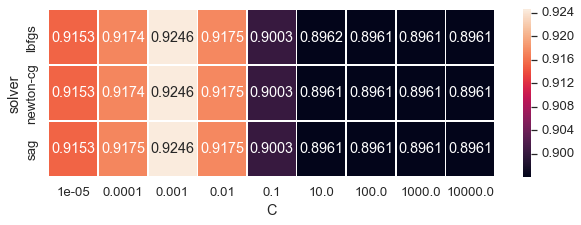

In [406]:
result = final_result[0][0]['params'].apply(pd.Series)
result['score'] = final_result[0][0]['mean_test_score']

plt.figure(figsize=(10,3))
heatmapdata = result.pivot('solver', "C", 'score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

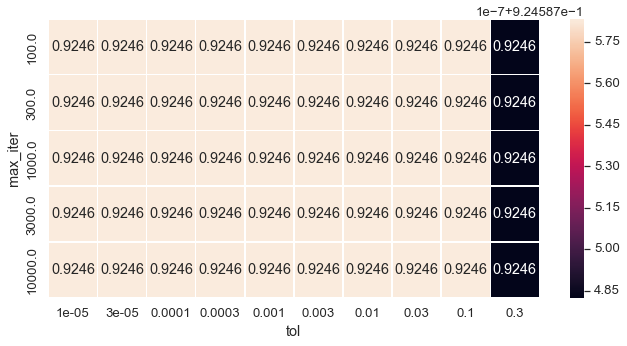

In [407]:
result = final_result[0][1]['params'].apply(pd.Series)
result['score'] = final_result[0][1]['mean_test_score']

plt.figure(figsize=(11,5))
heatmapdata = result.pivot('max_iter','tol','score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

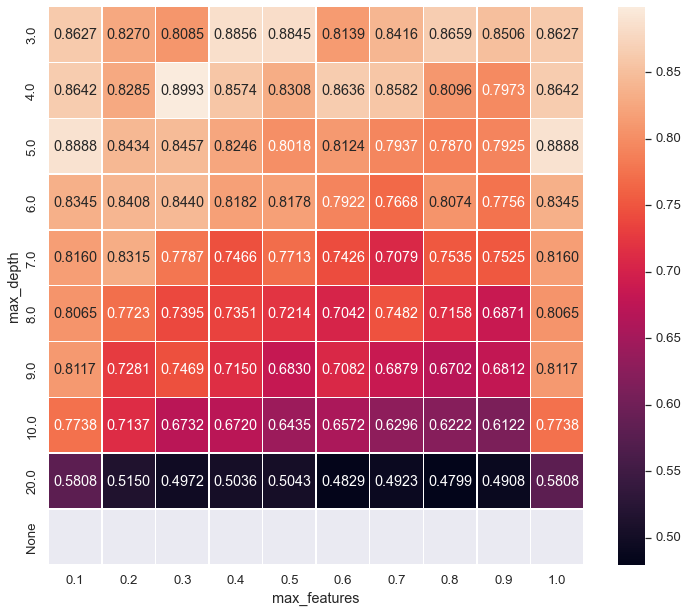

In [408]:
result = final_result[1][0]['params'].apply(pd.Series)
result['score'] = final_result[1][0]['mean_test_score']

plt.figure(figsize=(12,10))
heatmapdata = result.pivot('max_depth', 'max_features', 'score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

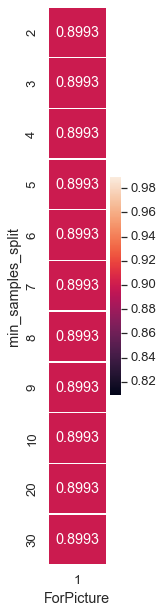

In [409]:
result = final_result[1][1]['params'].apply(pd.Series)
result['ForPicture'] = 1
result['score'] = final_result[1][1]['mean_test_score']

plt.figure(figsize=(1.3,10))
heatmapdata = result.pivot('min_samples_split','ForPicture','score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

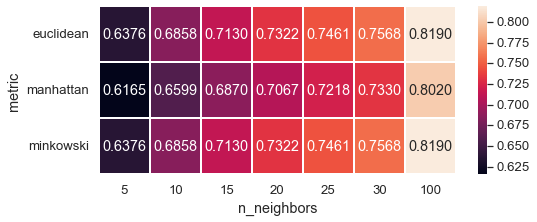

In [410]:
result = final_result[2][0]['params'].apply(pd.Series)
result['score'] = final_result[2][0]['mean_test_score']

plt.figure(figsize=(8,3))
heatmapdata = result.pivot('metric', 'n_neighbors', 'score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

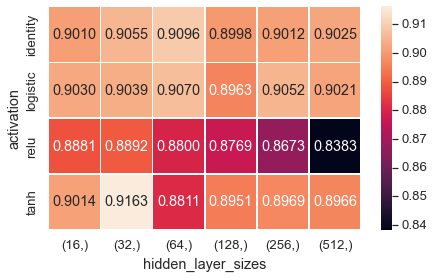

In [412]:
result = final_result[3][0]['params'].apply(pd.Series)
result['score'] = final_result[3][0]['mean_test_score']

plt.figure(figsize=(7,4))
heatmapdata = result.pivot('activation', 'hidden_layer_sizes', 'score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

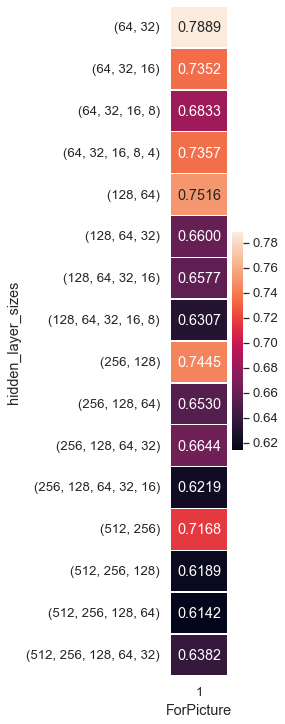

In [414]:
result = final_result[4][0]['params'].apply(pd.Series)
result['ForPicture'] = 1
result['score'] = final_result[4][0]['mean_test_score']

plt.figure(figsize=(1.3,12))
heatmapdata = result.pivot('hidden_layer_sizes','ForPicture','score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

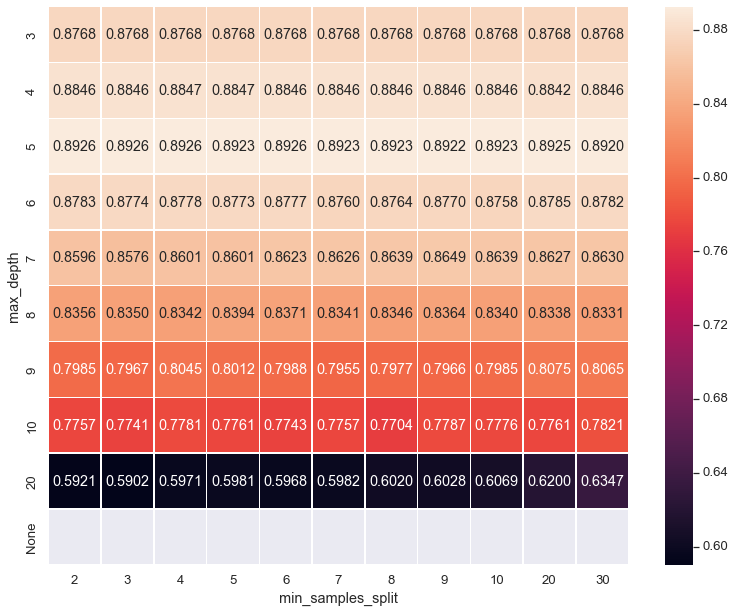

In [418]:
result = final_result[5][0]['params'].apply(pd.Series)
result['score'] = final_result[5][0]['mean_test_score']

plt.figure(figsize=(13,10))
heatmapdata = result.pivot('max_depth','min_samples_split','score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

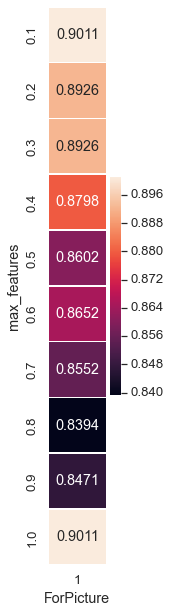

In [420]:
result = final_result[5][1]['params'].apply(pd.Series)
result['ForPicture'] = 1
result['score'] = final_result[5][1]['mean_test_score']

plt.figure(figsize=(1.3,10))
heatmapdata = result.pivot('max_features','ForPicture','score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

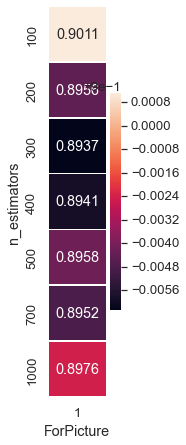

In [422]:
result = final_result[5][2]['params'].apply(pd.Series)
result['ForPicture'] = 1
result['score'] = final_result[5][2]['mean_test_score']

plt.figure(figsize=(1.3,7))
heatmapdata = result.pivot('n_estimators','ForPicture','score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

In [431]:
final_para[1]

{'criterion': 'gini',
 'splitter': 'best',
 'random_state': 42,
 'max_depth': 4,
 'max_features': 0.3,
 'min_samples_split': 2}

## Bagging

In [442]:
LR_Para1 = {'penalty': 'l2',
            'random_state': 42,
            'verbose': 0,
            'n_jobs': 8,
            'C': 0.001,
            'solver': 'lbfgs',
            'max_iter': 100,
            'tol': 0.1}
DT_Para1 = {'criterion': 'gini',
             'splitter': 'best',
             'random_state': 42,
             'max_depth': 4,
             'max_features': 0.3,
             'min_samples_split': 2}
KNN_Para1 = {'weights': 'uniform', 
             'algorithm': 'auto', 
             'metric': 'minkowski', 
             'n_neighbors': 100}
ANN_Para1 =  {'solver': 'adam', 
              'learning_rate': 'adaptive', 
              'max_iter': 2000, 
              'batch_size': 200, 
              'early_stopping': True, 
              'activation': 'relu', 
              'hidden_layer_sizes': (32,)}
MLP_Para1 = {'solver': 'adam',
             'learning_rate': 'adaptive',
             'activation': 'tanh',
             'max_iter': 2000,
             'batch_size': 200,
             'early_stopping': True,
             'hidden_layer_sizes': (64, 32)}
RF_Para1 =  {'criterion': 'gini',
             'random_state': 42,
             'max_depth': 5,
             'min_samples_split': 2,
             'max_features': 0.1,
             'n_estimators': 100}



def get_models():
    LR_HLS_1 = LogisticRegression(**LR_Para1)
    DT_HLS_1 =DecisionTreeClassifier(**DT_Para1)
    KNN_HLS_1= KNeighborsClassifier(**KNN_Para1)
    ANN_HLS_1 = MLPClassifier(**ANN_Para1)
    MLP_HLS_1 = MLPClassifier(**MLP_Para1)
    RF_HLS_1 = RandomForestClassifier(**RF_Para1)
    
    models ={'LR_HLS': LR_HLS_1,
             'DT_HLS': DT_HLS_1,
             'KNN_HLS':KNN_HLS_1,
             'ANN_HLS':ANN_HLS_1,
             'MLP_HLS':MLP_HLS_1,
             'RF_HLS':RF_HLS_1,
            }
    
    return models

In [443]:
aucresult1 = []
models = get_models()
X_Train = x_hlsp2
X_Test = x_hlsp1

y_Train =pd.DataFrame(y_hlsp2) 
y_Test = pd.DataFrame(y_hlsp1) 


Stacking_Train = pd.DataFrame(columns = models,index =X_Train.index)
Stacking_Test = pd.DataFrame(columns = models,index =X_Test.index)


for m in models:
    M1_oof_train, M1_oof_test = get_oof(models[m], X_Train, y_Train, X_Test)
    print(m,"Model K-Fold AUC Train score: %.4f  " % roc_auc_score(y_Train,pd.DataFrame(M1_oof_train,index=y_Train.index)),end='')
    print(m,"Model K-Fold AUC Test score: %.4f" % roc_auc_score(y_Test['A0'],pd.DataFrame(M1_oof_test,index=y_Test.index)))
    aucresult1.append(roc_auc_score(y_Test['A0'],pd.DataFrame(M1_oof_test,index=y_Test.index)))
    Stacking_Train[m] =  M1_oof_train.ravel()
    Stacking_Test[m] = M1_oof_test.ravel()

LR_HLS Model K-Fold AUC Train score: 0.8709  LR_HLS Model K-Fold AUC Test score: 0.8623
DT_HLS Model K-Fold AUC Train score: 0.8936  DT_HLS Model K-Fold AUC Test score: 0.8841
KNN_HLS Model K-Fold AUC Train score: 0.9379  KNN_HLS Model K-Fold AUC Test score: 0.9311
ANN_HLS Model K-Fold AUC Train score: 0.9126  ANN_HLS Model K-Fold AUC Test score: 0.9056
MLP_HLS Model K-Fold AUC Train score: 0.9327  MLP_HLS Model K-Fold AUC Test score: 0.9301
RF_HLS Model K-Fold AUC Train score: 0.9097  RF_HLS Model K-Fold AUC Test score: 0.8997


## Result od bagging and Stacking

In [449]:
Stacking = LogisticRegression().fit(Stacking_Train,y_Train)
print('Bagging training AUC score: %.4f' % roc_auc_score(y_Train,Stacking_Train.mean(axis=1)),end='')
print("  test AUC score: %.4f" % roc_auc_score(y_Test['A0'],Stacking_Test.mean(axis=1)))
print("LR stacking training AUC score: %.4f" % roc_auc_score(y_Train,Stacking.predict_proba(Stacking_Train)[:,1]),end='')
print("  test AUC score: %.4f" % roc_auc_score(y_Test['A0'],Stacking.predict_proba(Stacking_Test)[:,1]))

Bagging training AUC score: 0.9278  test AUC score: 0.9189
LR stacking training AUC score: 0.9407  test AUC score: 0.9354


In [450]:
ModelResult = Stacking_Train.copy()
ModelResult['Bagging'] = Stacking_Train.mean(axis=1)
ModelResult['Stacking'] =Stacking.predict_proba(Stacking_Train)[:,1]

ModelResult2 = Stacking_Test.copy()
ModelResult2['Bagging'] = Stacking_Test.mean(axis=1)
ModelResult2['Stacking'] =Stacking.predict_proba(Stacking_Test)[:,1]

In [459]:
ModelResult2.index = All_dataPo1.index
ModelResult2['X'] = All_dataPo1['XCoord']
ModelResult2['Y'] = All_dataPo1['YCoord']
ModelResult2['HLS'] = All_dataPo1['A0']
ModelResult2['ELS'] = All_dataPo1['A1']

In [96]:
def plot_map_point(Data,Labelvalues,Labletext,ColorLabel,var='A1',titles='Susceptibility map'):
    
    plt.figure(figsize=(15,10))
    
    for i in range(len(Labelvalues)):
        temp = Data[Data[var]==Labelvalues[i]]
        plt.scatter(temp['X'],temp['Y'],marker='o',color =ColorLabel[i] ,label=Labletext[i],s=0.5)
    
    plt.xticks(np.linspace(141.5,142.5,7),
           ['141$^{deg}$30$^{min}$E','141$^{deg}$40$^{min}$E','141$^{deg}$50$^{min}$E',
            '142$^{deg}$00$^{min}$E','142$^{deg}$10$^{min}$E','142$^{deg}$20$^{min}$E','142$^{deg}$30$^{min}$E'],fontsize=12);
    plt.xlim(141.7,142.4)

    plt.ylim(42.5,43.0)
    plt.yticks(np.linspace(42.5,43.0,4),
           ['42$^{deg}$30$^{min}$N','42$^{deg}$40$^{min}$N','42$^{deg}$50$^{min}$N','43$^{deg}$00$^{min}$N'],fontsize=12);

    plt.legend(loc = 'lower right',fontsize=16);
    plt.title(titles+' susceptibility map',fontsize=16)
    plt.show()

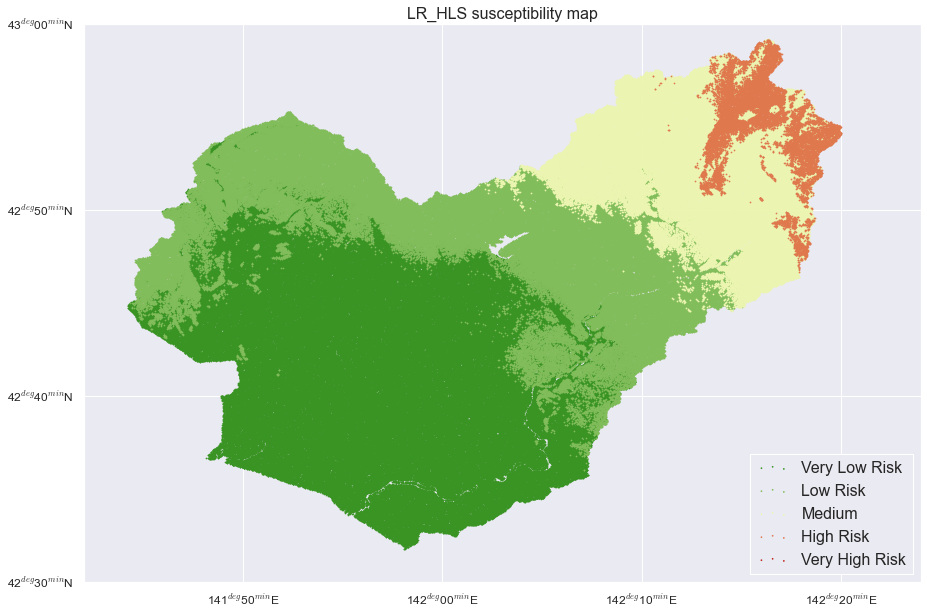

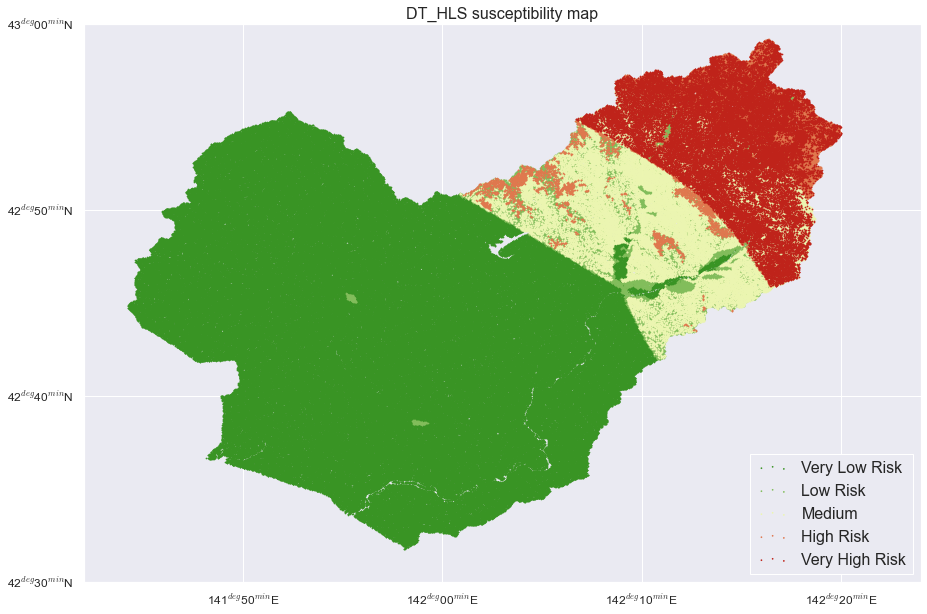

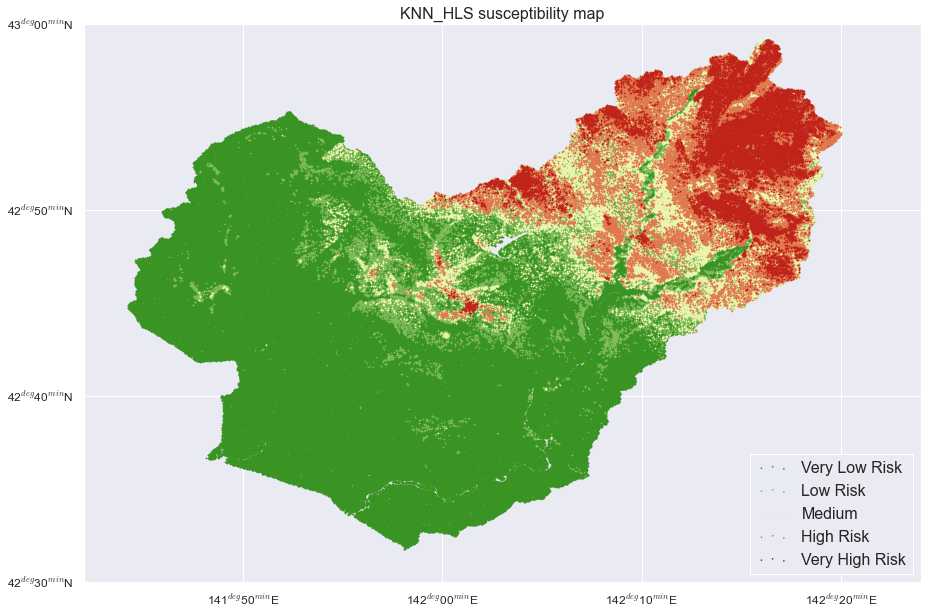

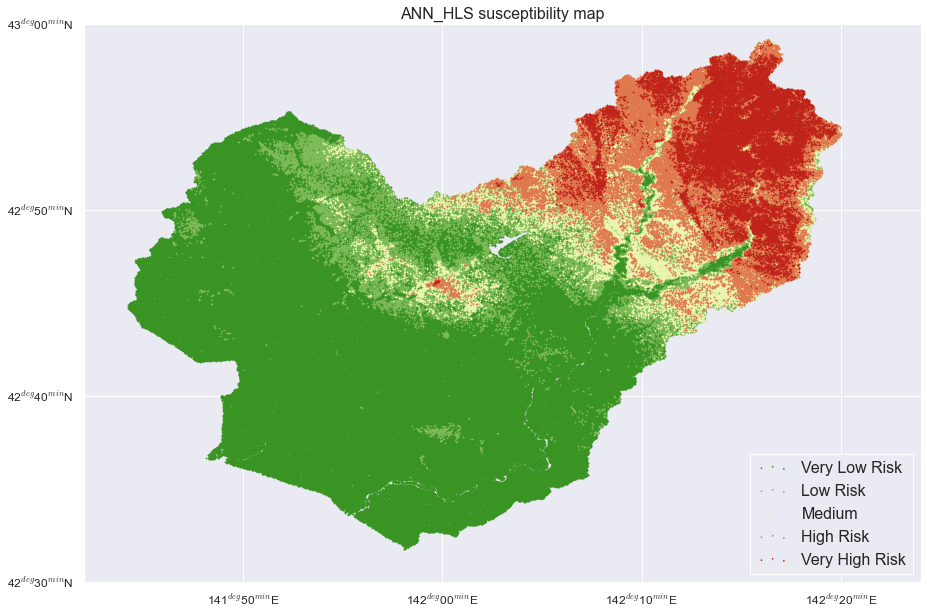

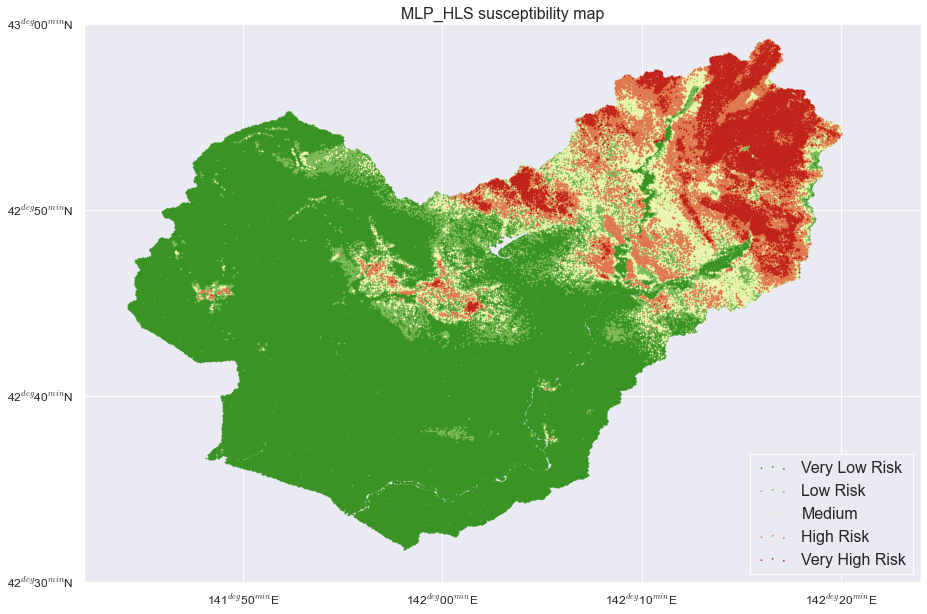

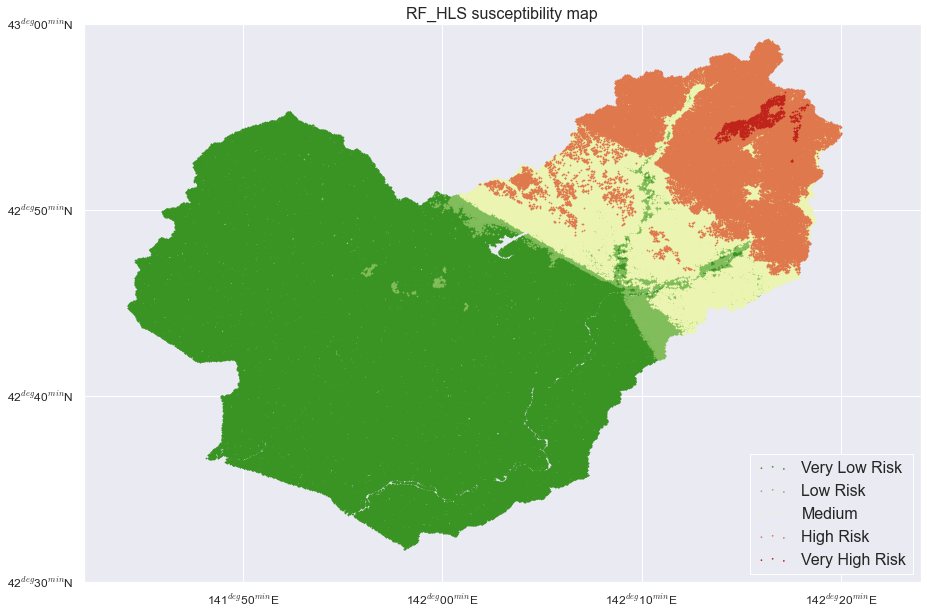

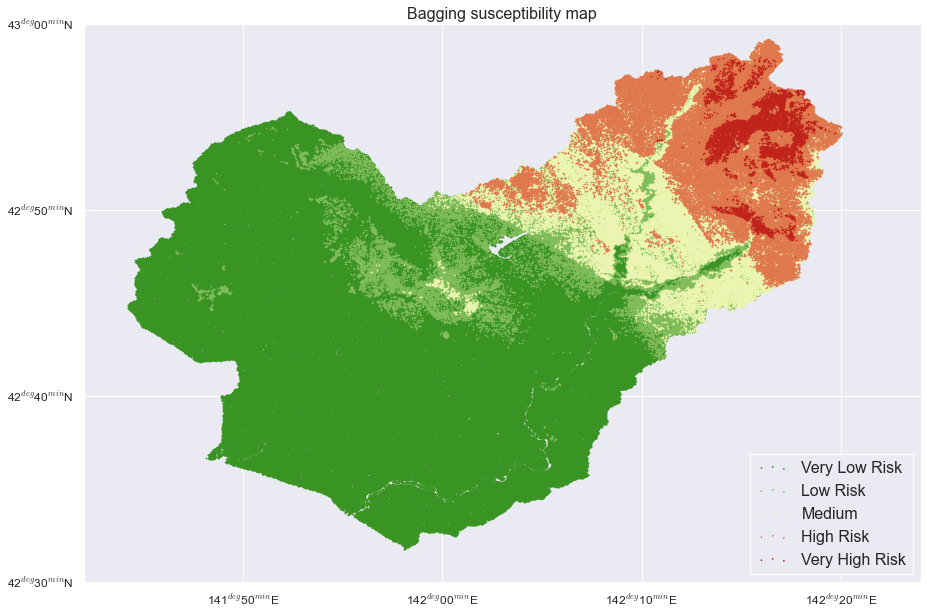

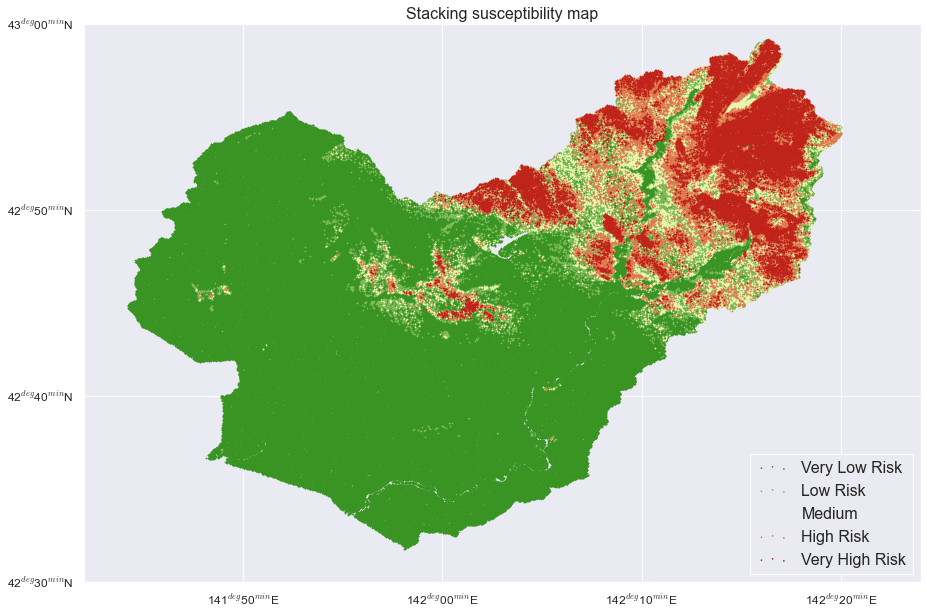

In [463]:
Labelvalues = ['Very Low Risk','Low Risk','Medium','High Risk','Very High Risk']
ColorLabel = ['#399424','#82BD5B','#ECF6B1','#E0784E','#BF231A']
bins = [-0.1,0.2,0.4,0.6,0.8,1.0]
TargetModel1 = ['LR_HLS','DT_HLS','KNN_HLS','ANN_HLS','MLP_HLS','RF_HLS','Bagging','Stacking']

for i in TargetModel1:
    ModelResult2['HLS_Risk'] = pd.cut(ModelResult2[i],bins,labels=['Very Low Risk','Low Risk',
                                                                      'Medium','High Risk','Very High Risk']) 

    plot_map_point(ModelResult2,Labelvalues,Labelvalues,ColorLabel,var='HLS_Risk',titles = i)

## Some Figure of HLS in model

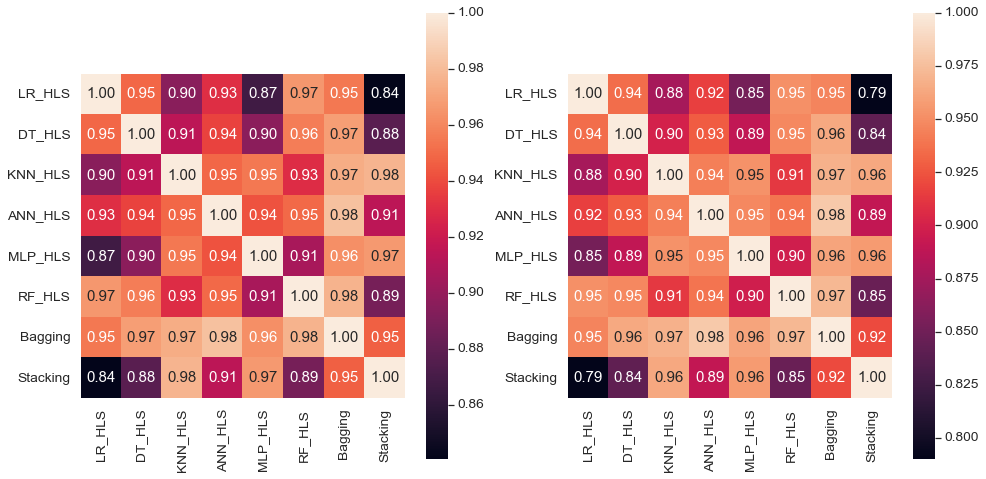

In [469]:
corrmat2= ModelResult.corr()
corrmat3= ModelResult2[list(ModelResult.columns)].corr()

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)

sns.set(font_scale=1.25)

hm = sns.heatmap(corrmat2,cbar=True,square=True,annot=True,fmt=".2f");
hm.set_ylim([corrmat2.shape[1], 0]);

plt.subplot(1,2,2)


sns.set(font_scale=1.25)

hm = sns.heatmap(corrmat3,cbar=True,square=True,annot=True,fmt=".2f");
hm.set_ylim([corrmat3.shape[1], 0]);

In [90]:
def plot_roc_curve(y_Test, P_learners, labels, title = 'Training dataset (Po2)'):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_learners.shape[1] + 1)]
    
    for i in range(P_learners.shape[1]):
        p = P_learners[:, i]
        fpr, tpr, _ = roc_curve(y_Test, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

        
    plt.xlabel('False positive rate',fontsize=14)
    plt.ylabel('True positive rate',fontsize=14)
    plt.title(title,fontsize=18)
    plt.legend(loc = 'lower right',title_fontsize=14,fontsize=14)
    plt.show()

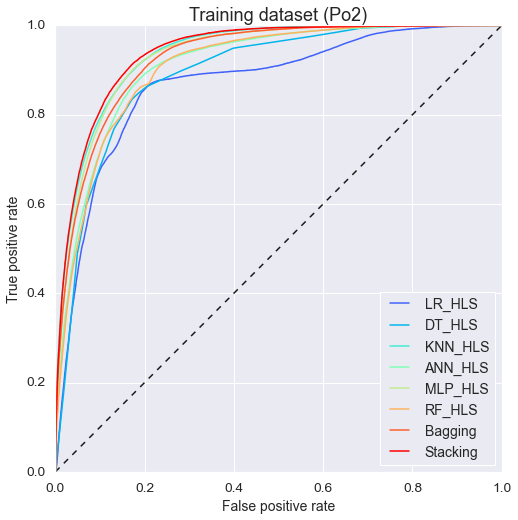

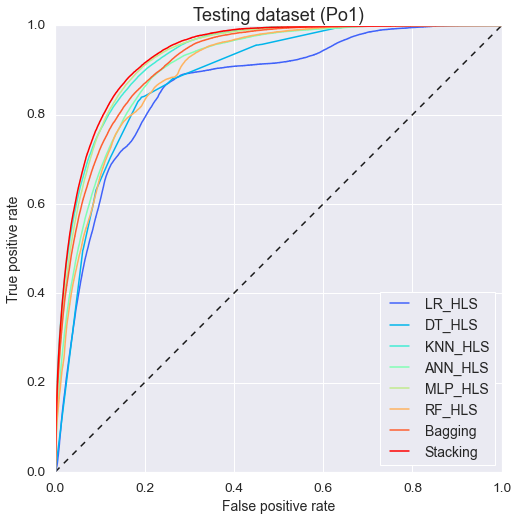

In [472]:
plot_roc_curve(y_Train, ModelResult.values, list(ModelResult.columns),title = 'Training dataset (Po2)')
plot_roc_curve(y_Test, ModelResult2[list(ModelResult.columns)].values, list(ModelResult.columns),title = 'Testing dataset (Po1)')

## factor importance

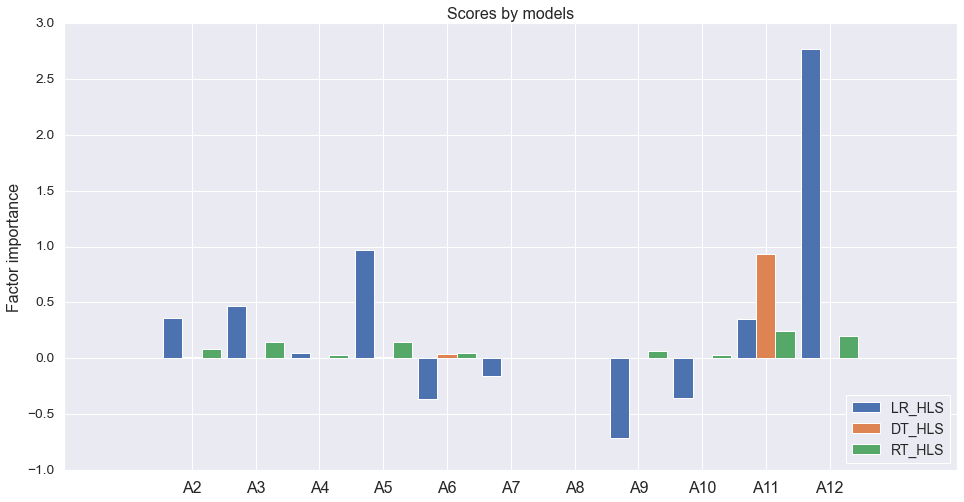

In [473]:
labels = ['A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12']
LR_HLS_factip =  models['LR_HLS'].coef_.reshape(11,)
DT_HLS_factip =  models['DT_HLS'].feature_importances_.reshape(11,)
RT_HLS_factip =  models['RF_HLS'].feature_importances_.reshape(11,)


x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, LR_HLS_factip , width, label='LR_HLS')
rects2 = ax.bar(x        , DT_HLS_factip , width, label='DT_HLS')
rects2 = ax.bar(x + width, RT_HLS_factip , width, label='RT_HLS')


ax.set_ylabel('Factor importance',fontsize=16)
ax.set_title('Scores by models',fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=16)
ax.legend(loc = 'lower right',title_fontsize=14,fontsize=14)    

In [474]:
factip =pd.DataFrame({'LR_HLS' : models['LR_HLS'].coef_.reshape(11,),
                     'DT_HLS' : models['DT_HLS'].feature_importances_.reshape(11,),
                     'RF_HLS' : models['RF_HLS'].feature_importances_.reshape(11,)},
                    index = ['A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12'] )

In [475]:
factip

LR_HLS    DT_HLS    RF_HLS
A2   0.357181  0.006672  0.086688
A3   0.468127  0.000073  0.147988
A4   0.043395  0.004423  0.028115
A5   0.973586  0.007172  0.144492
A6  -0.364726  0.040178  0.048465
A7  -0.163657  0.000000  0.004599
A8   0.006223  0.000000  0.004472
A9  -0.714704  0.001075  0.068315
A10 -0.356843  0.000341  0.025893
A11  0.355094  0.933866  0.239627
A12  2.767085  0.006200  0.201344

# ELS ANALYSIS

## LR

In [32]:
initial_params ={'penalty':'l2',
                 'random_state':SEED,
                 'verbose':0,
                 'n_jobs':8}

params_test1 = {'solver': ['newton-cg','sag','lbfgs'],
                'C':[1e-5,1e-4,1e-3,1e-2,1e-1,0,10,100,1000,10000]}
params_test2 = {'tol':[1e-1,3e-1,1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5],
                'max_iter':[100,300,1000,3000,10000]}
                       
               
params_turns = 2

#开始采用贪心算法对参数进行搜索，返回的initial_params为获取的最佳参数
df_cv_result=[]
for i in range(params_turns):
    params_string = "params_test"+str(i+1)
    params_round = locals()[params_string]
    print('----------------------Finding Parameters,',params_string,'--------------------------') 
    print('Parameters:',params_string,params_round)
    
    gsearch = GridSearchCV(estimator = LogisticRegression(**initial_params), 
                           param_grid = params_round, scoring='roc_auc',cv=5,n_jobs=9)
    
    print('Start Fiting,',params_string)          
    %time gsearch.fit(x_elsp2,y_elsp2)
    print(gsearch.best_params_,'Best evaluation Scores',gsearch.best_score_)
    
    initial_params.update(gsearch.best_params_)    
    df_cv_result.append(pd.DataFrame(gsearch.cv_results_))
    
final_result2=[]
final_para2=[]
final_result2.append(df_cv_result)
final_para2.append(initial_params)

----------------------Finding Parameters, params_test1 --------------------------
Parameters: params_test1 {'solver': ['newton-cg', 'sag', 'lbfgs'], 'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0, 10, 100, 1000, 10000]}
Start Fiting, params_test1
Wall time: 48.5 s
{'C': 0.001, 'solver': 'sag'} Best evaluation Scores 0.9216388070142447
----------------------Finding Parameters, params_test2 --------------------------
Parameters: params_test2 {'tol': [0.1, 0.3, 0.01, 0.03, 0.001, 0.003, 0.0001, 0.0003, 1e-05, 3e-05], 'max_iter': [100, 300, 1000, 3000, 10000]}
Start Fiting, params_test2
Wall time: 15.1 s
{'max_iter': 100, 'tol': 0.1} Best evaluation Scores 0.9216575560269025


## DT

In [33]:
initial_params ={'criterion':'gini',
                 'splitter':'best',
                 'random_state':SEED}


params_test1 = {'max_depth': [3,4,5,6,7,8,9,10,20,'None'],
                'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
params_test2 = {'min_samples_split':[2,3,4,5,6,7,8,9,10,20,30]}

params_turns = 2

df_cv_result=[]
for i in range(params_turns):
    params_string = "params_test"+str(i+1)
    params_round = locals()[params_string]
    print('----------------------Finding Parameters,',params_string,'--------------------------') 
    print('Parameters:',params_string,params_round)
    
    gsearch = GridSearchCV(estimator = DecisionTreeClassifier(**initial_params), 
                           param_grid = params_round, scoring='roc_auc',cv=5,n_jobs=9)
    
    print('Start Fiting,',params_string)          
    %time gsearch.fit(x_elsp2,y_elsp2)
    print(gsearch.best_params_,'Best evaluation Scores',gsearch.best_score_)
    
    
    initial_params.update(gsearch.best_params_)    
    df_cv_result.append(pd.DataFrame(gsearch.cv_results_))
    
    
final_result2.append(df_cv_result)
final_para2.append(initial_params)

----------------------Finding Parameters, params_test1 --------------------------
Parameters: params_test1 {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 20, 'None'], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
Start Fiting, params_test1
Wall time: 29.1 s
{'max_depth': 4, 'max_features': 0.1} Best evaluation Scores 0.889640731105619
----------------------Finding Parameters, params_test2 --------------------------
Parameters: params_test2 {'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]}
Start Fiting, params_test2
Wall time: 1.33 s
{'min_samples_split': 2} Best evaluation Scores 0.889640731105619


## KNN

In [34]:
initial_params ={'weights':'uniform',
                 'algorithm':'auto'}


params_test1 = {'n_neighbors': [5,10,15,20,25,30,100],
                'metric':['minkowski','euclidean','manhattan']} 

params_turns = 1

#KNeighborsClassifier
df_cv_result=[]
for i in range(params_turns):
    params_string = "params_test"+str(i+1)
    params_round = locals()[params_string]
    print('----------------------Finding Parameters,',params_string,'--------------------------') 
    print('Parameters:',params_string,params_round)
    
    gsearch = GridSearchCV(estimator = KNeighborsClassifier(**initial_params), 
                           param_grid = params_round, scoring='roc_auc',cv=5,n_jobs=9)
    
    print('Start Fiting,',params_string)          
    %time gsearch.fit(x_elsp2,y_elsp2)
    print(gsearch.best_params_,'Best evaluation Scores',gsearch.best_score_)
    
    initial_params.update(gsearch.best_params_)    
    df_cv_result.append(pd.DataFrame(gsearch.cv_results_))
    
    
final_result2.append(df_cv_result)
final_para2.append(initial_params)

----------------------Finding Parameters, params_test1 --------------------------
Parameters: params_test1 {'n_neighbors': [5, 10, 15, 20, 25, 30, 100], 'metric': ['minkowski', 'euclidean', 'manhattan']}
Start Fiting, params_test1
Wall time: 4min 41s
{'metric': 'minkowski', 'n_neighbors': 100} Best evaluation Scores 0.7960655653621286


## ANN

In [35]:
initial_params ={'solver':'adam',
                 'learning_rate':'adaptive',
                 'max_iter':2000,
                 'batch_size':200,
                 'early_stopping':True}


params_test1 = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
                'hidden_layer_sizes':[(16,),(32,),(64,),(128,),(256,),(512,)]}

params_turns = 1
# MLPClassifier

df_cv_result=[]
for i in range(params_turns):
    params_string = "params_test"+str(i+1)
    params_round = locals()[params_string]
    print('----------------------Finding Parameters,',params_string,'--------------------------') 
    print('Parameters:',params_string,params_round)
    
    gsearch = GridSearchCV(estimator = MLPClassifier(**initial_params), 
                           param_grid = params_round, scoring='roc_auc',cv=5,n_jobs=9)
    
    print('Start Fiting,',params_string)          
    %time gsearch.fit(x_elsp2,y_elsp2)
    print(gsearch.best_params_,'Best evaluation Scores',gsearch.best_score_)
    
    lr_oof_trainp2, lr_oof_testp2  = get_oof(MLPClassifier(**initial_params), x_elsp2, y_elsp2, x_elsp1)
    print("This parameter in Testing Dataset AUC score: %.4f" % roc_auc_score(y_elsp1,lr_oof_testp2))
    
    initial_params.update(gsearch.best_params_)
    
    df_cv_result.append(pd.DataFrame(gsearch.cv_results_))
    
final_result2.append(df_cv_result)
final_para2.append(initial_params)

----------------------Finding Parameters, params_test1 --------------------------
Parameters: params_test1 {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'hidden_layer_sizes': [(16,), (32,), (64,), (128,), (256,), (512,)]}
Start Fiting, params_test1
Wall time: 12min 2s
{'activation': 'logistic', 'hidden_layer_sizes': (256,)} Best evaluation Scores 0.9114627145159918
This parameter in Testing Dataset AUC score: 0.9506


In [36]:
initial_params ={'solver':'adam',
                 'learning_rate':'adaptive',
                 'activation':'logistic',
                 'max_iter':2000,
                 'batch_size':200,
                 'early_stopping':True}

params_test1 = {'hidden_layer_sizes':[(128,64),(128,64,32),(128,64,32,16),(128,64,32,16,8)]}

params_turns = 1


df_cv_result=[]
for i in range(params_turns):
    params_string = "params_test"+str(i+1)
    params_round = locals()[params_string]
    print('----------------------Finding Parameters,',params_string,'--------------------------') 
    print('Parameters:',params_string,params_round)
    
    gsearch = GridSearchCV(estimator = MLPClassifier(**initial_params), 
                           param_grid = params_round, scoring='roc_auc',cv=5,n_jobs=9)
    
    print('Start Fiting,',params_string)          
    %time gsearch.fit(x_elsp2,y_elsp2)
    print(gsearch.best_params_,'Best evaluation Scores',gsearch.best_score_)
    
    lr_oof_trainp2, lr_oof_testp2  = get_oof(MLPClassifier(**initial_params), x_elsp2, y_elsp2, x_elsp1)
    print("This parameter in Testing Dataset AUC score: %.4f" % roc_auc_score(y_elsp1,lr_oof_testp2))
    
    initial_params.update(gsearch.best_params_)
    
    df_cv_result.append(pd.DataFrame(gsearch.cv_results_))
    
final_result2.append(df_cv_result)
final_para2.append(initial_params)

----------------------Finding Parameters, params_test1 --------------------------
Parameters: params_test1 {'hidden_layer_sizes': [(128, 64), (128, 64, 32), (128, 64, 32, 16), (128, 64, 32, 16, 8)]}
Start Fiting, params_test1
Wall time: 6min 39s
{'hidden_layer_sizes': (128, 64, 32)} Best evaluation Scores 0.903982943521149
This parameter in Testing Dataset AUC score: 0.9208


## RF

In [37]:
initial_params ={'criterion':'gini',
                 'random_state':SEED}


params_test1 = {'max_depth': [3,4,5,6,7,8,9,10,20,'None'],
                'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
params_test2 = {'min_samples_split':[2,3,4,5,6,7,8,9,10,20,30],
                'n_estimators':[100,200,300,400,500]}


params_turns = 2


df_cv_result=[]
for i in range(params_turns):
    params_string = "params_test"+str(i+1)
    params_round = locals()[params_string]
    print('----------------------Finding Parameters,',params_string,'--------------------------') 
    print('Parameters:',params_string,params_round)
    
    gsearch = GridSearchCV(estimator = RandomForestClassifier(**initial_params), 
                           param_grid = params_round, scoring='roc_auc',cv=5,n_jobs=9)
    
    print('Start Fiting,',params_string)          
    %time gsearch.fit(x_elsp2,y_elsp2)
    print(gsearch.best_params_,'Best evaluation Scores',gsearch.best_score_)
    
    lr_oof_trainp2, lr_oof_testp2  = get_oof(RandomForestClassifier(**initial_params), x_elsp2, y_elsp2, x_elsp1)
    print("This parameter in Testing Dataset AUC score: %.4f" % roc_auc_score(y_elsp1,lr_oof_testp2))
    
    initial_params.update(gsearch.best_params_)
    
    df_cv_result.append(pd.DataFrame(gsearch.cv_results_))
    
final_result2.append(df_cv_result)
final_para2.append(initial_params)

----------------------Finding Parameters, params_test1 --------------------------
Parameters: params_test1 {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 20, 'None'], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
Start Fiting, params_test1
Wall time: 30min 54s
{'max_depth': 3, 'max_features': 0.1} Best evaluation Scores 0.9262830522122105
This parameter in Testing Dataset AUC score: 0.9798
----------------------Finding Parameters, params_test2 --------------------------
Parameters: params_test2 {'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30], 'n_estimators': [100, 200, 300, 400, 500, 700, 1000]}
Start Fiting, params_test2
Wall time: 13min 11s
{'min_samples_split': 2, 'n_estimators': 400} Best evaluation Scores 0.9276612481888412
This parameter in Testing Dataset AUC score: 0.9353


## GS

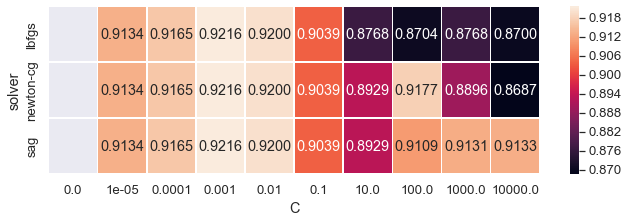

In [39]:
result = final_result2[0][0]['params'].apply(pd.Series)
result['score'] = final_result2[0][0]['mean_test_score']

plt.figure(figsize=(11,3))
heatmapdata = result.pivot('solver', "C", 'score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

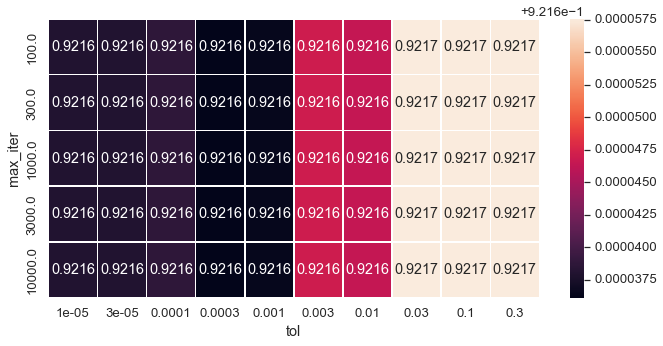

In [44]:
result = final_result2[0][1]['params'].apply(pd.Series)
result['score'] = final_result2[0][1]['mean_test_score']

plt.figure(figsize=(11,5))
heatmapdata = result.pivot( 'max_iter','tol', 'score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

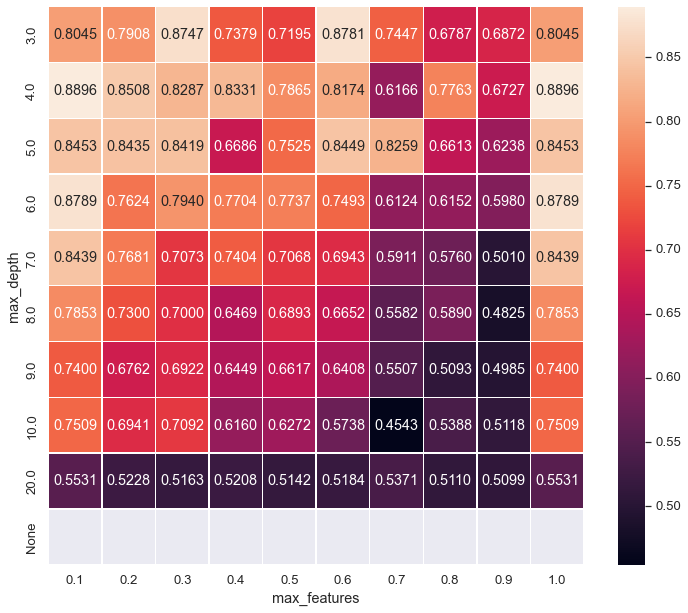

In [45]:
result = final_result2[1][0]['params'].apply(pd.Series)
result['score'] = final_result2[1][0]['mean_test_score']

plt.figure(figsize=(12,10))
heatmapdata = result.pivot('max_depth', 'max_features', 'score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

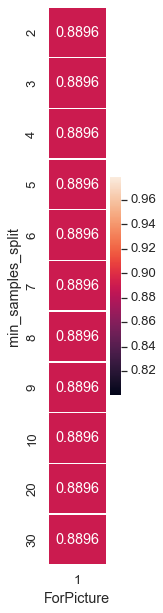

In [46]:
result = final_result2[1][1]['params'].apply(pd.Series)
result['ForPicture'] = 1
result['score'] = final_result2[1][1]['mean_test_score']

plt.figure(figsize=(1.3,10))
heatmapdata = result.pivot('min_samples_split','ForPicture','score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

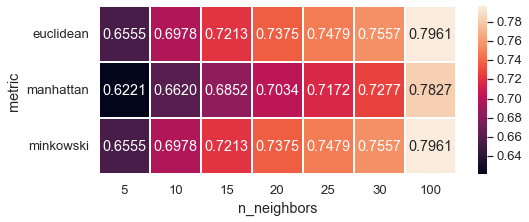

In [47]:
result = final_result2[2][0]['params'].apply(pd.Series)
result['score'] = final_result2[2][0]['mean_test_score']

plt.figure(figsize=(8,3))
heatmapdata = result.pivot('metric', 'n_neighbors', 'score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

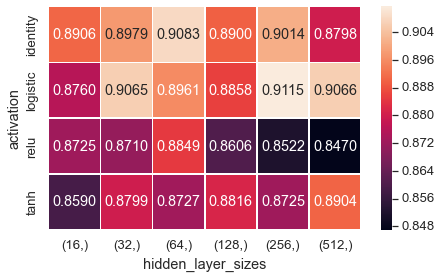

In [48]:
result = final_result2[3][0]['params'].apply(pd.Series)
result['score'] = final_result2[3][0]['mean_test_score']

plt.figure(figsize=(7,4))
heatmapdata = result.pivot('activation', 'hidden_layer_sizes', 'score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

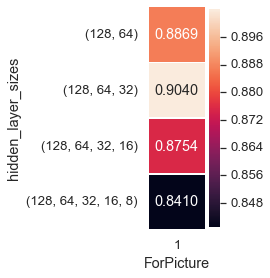

In [50]:
result = final_result2[4][0]['params'].apply(pd.Series)
result['ForPicture'] = 1
result['score'] = final_result2[4][0]['mean_test_score']

plt.figure(figsize=(1.3,4))
heatmapdata = result.pivot('hidden_layer_sizes','ForPicture','score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

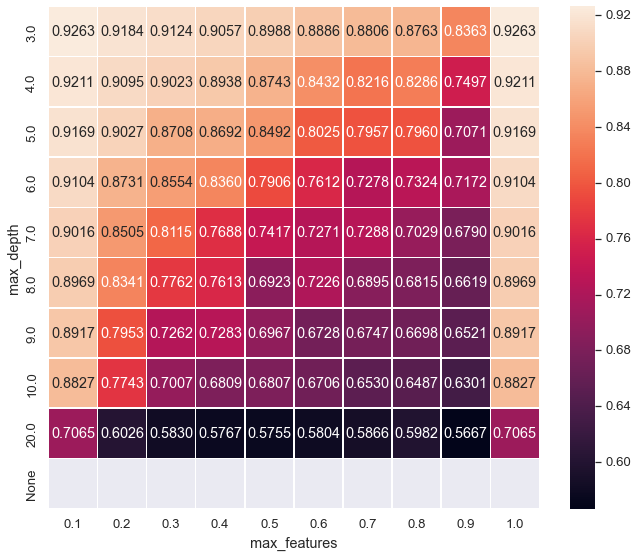

In [53]:
result = final_result2[5][0]['params'].apply(pd.Series)
result['score'] = final_result2[5][0]['mean_test_score']

plt.figure(figsize=(11,9))
heatmapdata = result.pivot('max_depth','max_features', 'score')
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

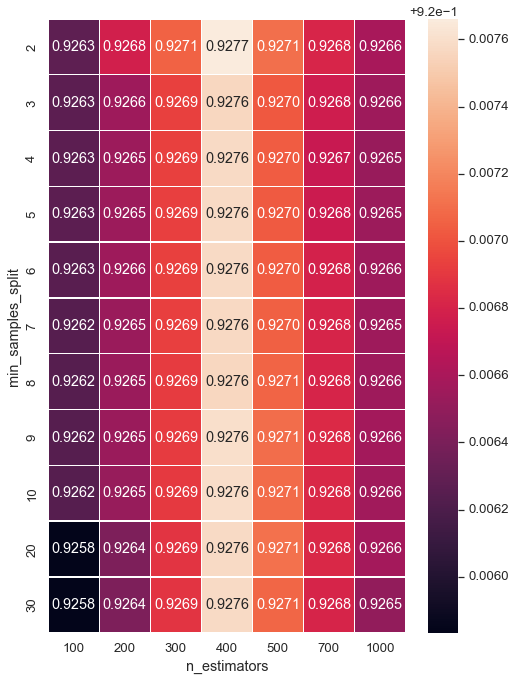

In [69]:
result = final_result2[5][1]['params'].apply(pd.Series)
result['score'] = final_result2[5][1]['mean_test_score']

X_axls_len = len(result[list(result.columns)[1]].unique())+1
Y_axls_len = len(result[list(result.columns)[0]].unique())

plt.figure(figsize=(X_axls_len,Y_axls_len))
heatmapdata = result.pivot(index=list(result.columns)[0], columns=list(result.columns)[1], values=list(result.columns)[2])
sns.set(font_scale=1.2)
GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

plt.savefig(Picture_result+'/'+list(result.columns)[0]+'.png')

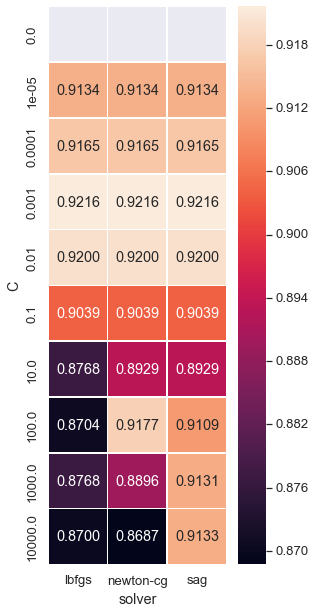

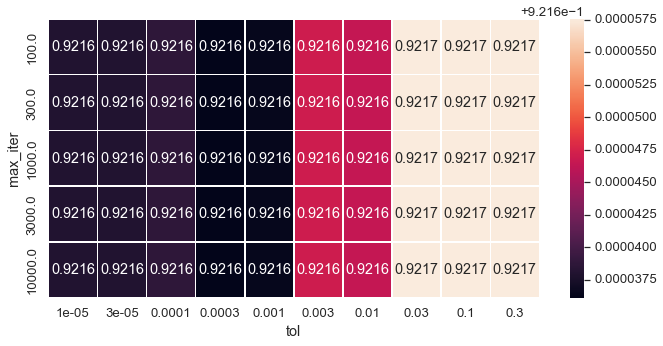

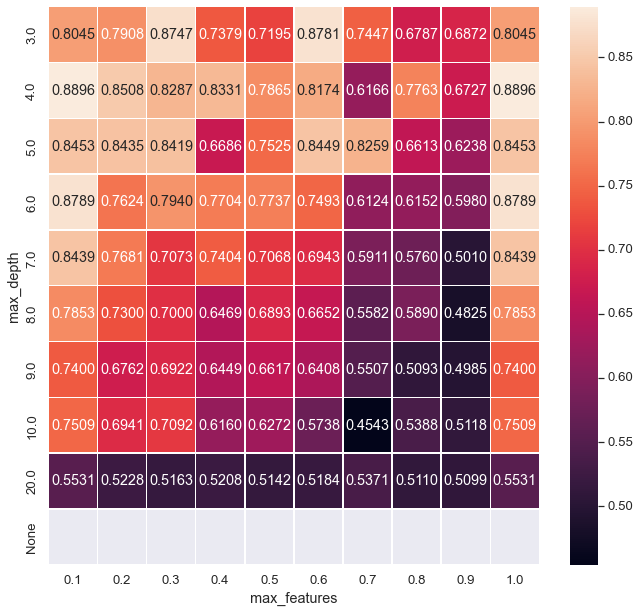

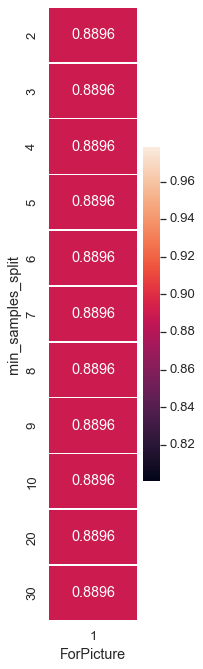

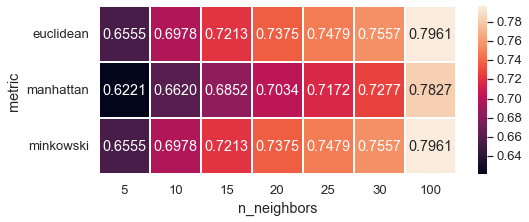

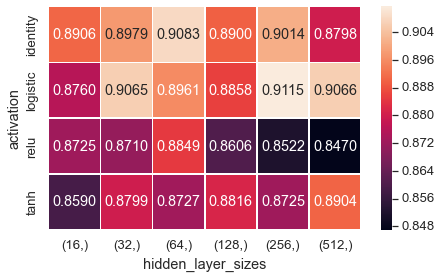

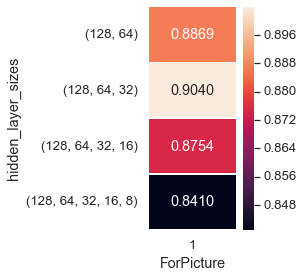

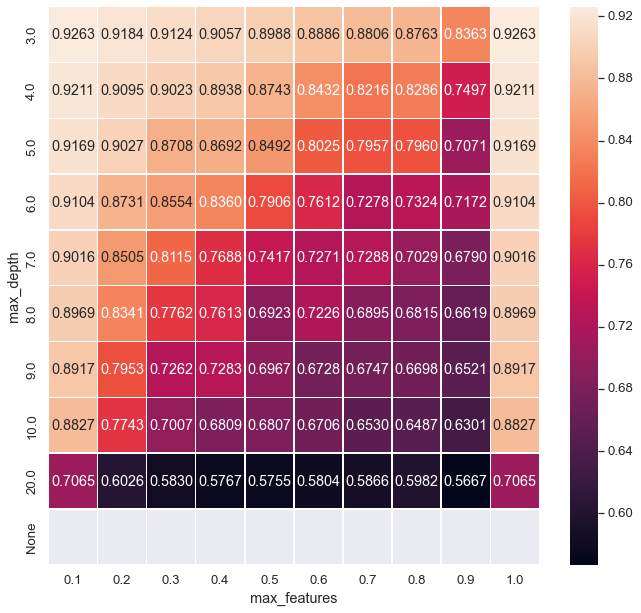

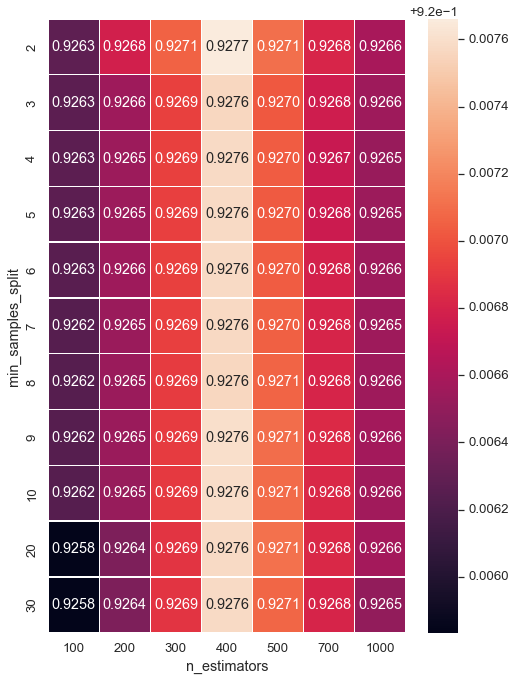

In [78]:
Filename = ['LR','DT','KNN','ANN','MLP','RF']

for i in range(len(final_result2)):
    for j in range(len(final_result2[i])):
        result = final_result2[i][j]['params'].apply(pd.Series)   
        if len(result.columns) == 1 :
            result['ForPicture'] = 1
        result['score'] = final_result2[i][j]['mean_test_score']
        
        X_axls_len = len(result[list(result.columns)[1]].unique())+1
        Y_axls_len = len(result[list(result.columns)[0]].unique())
            
        plt.figure(figsize=(X_axls_len,Y_axls_len))
        heatmapdata = result.pivot(index=list(result.columns)[0], columns=list(result.columns)[1], values=list(result.columns)[2])
        sns.set(font_scale=1.2)
        GFheatmap = sns.heatmap(heatmapdata, annot=True, fmt=".4f",linewidths=.5)

        plt.savefig(Picture_result+'/'+Filename[i]+str(j)+'.png')    


## Bagging

In [82]:
final_para2

[{'penalty': 'l2',
  'random_state': 42,
  'verbose': 0,
  'n_jobs': 8,
  'C': 0.001,
  'solver': 'sag',
  'max_iter': 100,
  'tol': 0.1},
 {'criterion': 'gini',
  'splitter': 'best',
  'random_state': 42,
  'max_depth': 4,
  'max_features': 0.1,
  'min_samples_split': 2},
 {'weights': 'uniform',
  'algorithm': 'auto',
  'metric': 'minkowski',
  'n_neighbors': 100},
 {'solver': 'adam',
  'learning_rate': 'adaptive',
  'max_iter': 2000,
  'batch_size': 200,
  'early_stopping': True,
  'activation': 'logistic',
  'hidden_layer_sizes': (256,)},
 {'solver': 'adam',
  'learning_rate': 'adaptive',
  'activation': 'logistic',
  'max_iter': 2000,
  'batch_size': 200,
  'early_stopping': True,
  'hidden_layer_sizes': (128, 64, 32)},
 {'criterion': 'gini',
  'random_state': 42,
  'max_depth': 3,
  'max_features': 0.1,
  'min_samples_split': 2,
  'n_estimators': 400}]

In [83]:
LR_Para2 =final_para2[0]
DT_Para2 = final_para2[1]
KNN_Para2 = final_para2[2]
ANN_Para2 = final_para2[3]
MLP_Para2 = final_para2[4]
RF_Para2 =  final_para2[5]

def get_models2():
    LR_ELS_2 = LogisticRegression(**LR_Para2)
    DT_ELS_2 =DecisionTreeClassifier(**DT_Para2)
    KNN_ELS_2= KNeighborsClassifier(**KNN_Para2)
    ANN_ELS_2 = MLPClassifier(**ANN_Para2)
    MLP_ELS_2 = MLPClassifier(**MLP_Para2)
    RF_ELS_2 = RandomForestClassifier(**RF_Para2)
    
    models ={'LR_ELS': LR_ELS_2,
             'DT_ELS': DT_ELS_2,
             'KNN_ELS':KNN_ELS_2,
             'ANN_ELS':ANN_ELS_2,
             'MLP_ELS':MLP_ELS_2,
             'RF_ELS':RF_ELS_2,
            }
    
    return models

In [85]:
aucresult2 = []
models = get_models2()
X_Train = x_elsp2
X_Test = x_elsp1

y_Train =pd.DataFrame(y_elsp2) 
y_Test = pd.DataFrame(y_elsp1) 


Stacking_Train2 = pd.DataFrame(columns = models,index =X_Train.index)
Stacking_Test2 = pd.DataFrame(columns = models,index =X_Test.index)


for m in models:
    M1_oof_train, M1_oof_test = get_oof(models[m], X_Train, y_Train, X_Test)
    print(m,"Model K-Fold AUC Train score: %.4f  " % roc_auc_score(y_Train,pd.DataFrame(M1_oof_train,index=y_Train.index)),end='')
    print(m,"Model K-Fold AUC Test score: %.4f" % roc_auc_score(y_Test['A1'],pd.DataFrame(M1_oof_test,index=y_Test.index)))
    aucresult2.append(roc_auc_score(y_Test['A1'],pd.DataFrame(M1_oof_test,index=y_Test.index)))
    Stacking_Train2[m] =  M1_oof_train.ravel()
    Stacking_Test2[m] = M1_oof_test.ravel()

LR_ELS Model K-Fold AUC Train score: 0.9240  LR_ELS Model K-Fold AUC Test score: 0.9154
DT_ELS Model K-Fold AUC Train score: 0.9169  DT_ELS Model K-Fold AUC Test score: 0.9036
KNN_ELS Model K-Fold AUC Train score: 0.9569  KNN_ELS Model K-Fold AUC Test score: 0.9543
ANN_ELS Model K-Fold AUC Train score: 0.9335  ANN_ELS Model K-Fold AUC Test score: 0.9274
MLP_ELS Model K-Fold AUC Train score: 0.9331  MLP_ELS Model K-Fold AUC Test score: 0.9286
RF_ELS Model K-Fold AUC Train score: 0.9397  RF_ELS Model K-Fold AUC Test score: 0.9356


In [86]:
Stacking = LogisticRegression().fit(Stacking_Train2,y_Train)
print('Bagging training AUC score: %.4f' % roc_auc_score(y_Train,Stacking_Train2.mean(axis=1)),end='')
print("  test AUC score: %.4f" % roc_auc_score(y_Test['A1'],Stacking_Test2.mean(axis=1)))
print("LR stacking training AUC score: %.4f" % roc_auc_score(y_Train,Stacking.predict_proba(Stacking_Train2)[:,1]),end='')
print("  test AUC score: %.4f" % roc_auc_score(y_Test['A1'],Stacking.predict_proba(Stacking_Test2)[:,1]))

Bagging training AUC score: 0.9461  test AUC score: 0.9415
LR stacking training AUC score: 0.9565  test AUC score: 0.9543


## Picture

In [87]:
ModelResult3 = Stacking_Train2.copy()
ModelResult3['Bagging2'] = Stacking_Train2.mean(axis=1)
ModelResult3['Stacking2'] =Stacking.predict_proba(Stacking_Train2)[:,1]

ModelResult4 = Stacking_Test2.copy()
ModelResult4['Bagging2'] = Stacking_Test2.mean(axis=1)
ModelResult4['Stacking2'] =Stacking.predict_proba(Stacking_Test2)[:,1]

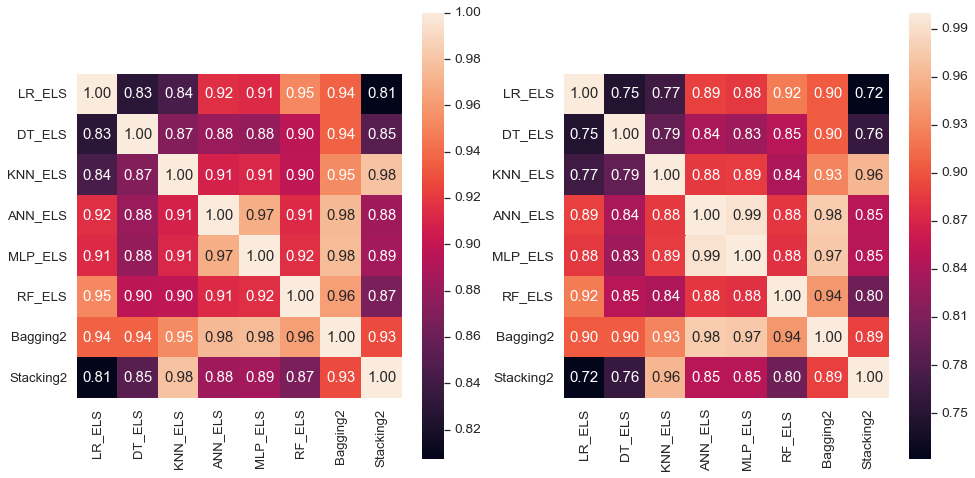

In [88]:
corrmat4= ModelResult3.corr()
corrmat5= ModelResult4.corr()

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.set(font_scale=1.25)

hm = sns.heatmap(corrmat4,cbar=True,square=True,annot=True,fmt=".2f");
hm.set_ylim([ModelResult3.shape[1], 0]);

plt.subplot(1,2,2)


sns.set(font_scale=1.25)

hm = sns.heatmap(corrmat5,cbar=True,square=True,annot=True,fmt=".2f");
hm.set_ylim([ModelResult4.shape[1], 0]);

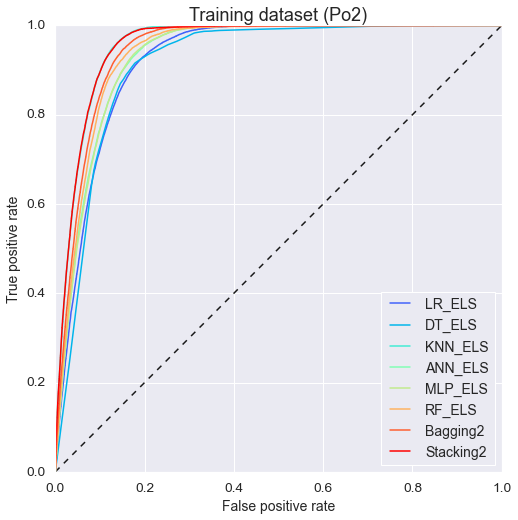

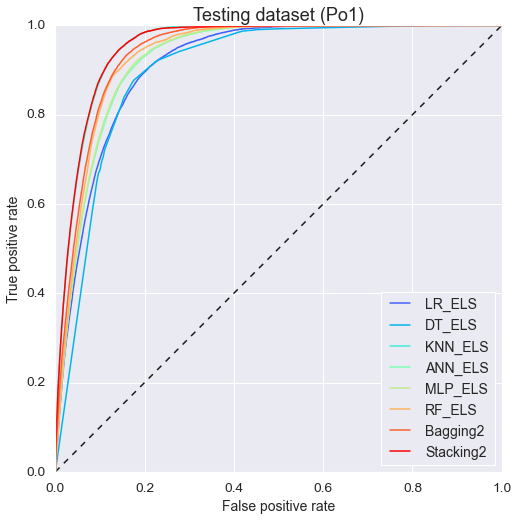

In [91]:
plot_roc_curve(y_Train, ModelResult3.values, list(ModelResult3.columns),title = 'Training dataset (Po2)')
plot_roc_curve(y_Test, ModelResult4.values, list(ModelResult4.columns),title = 'Testing dataset (Po1)')

In [92]:
factip =pd.DataFrame({'LR_ELS' : models['LR_ELS'].coef_.reshape(18,),
                     'DT_ELS' : models['DT_ELS'].feature_importances_.reshape(18,),
                     'RF_ELS' : models['RF_ELS'].feature_importances_.reshape(18,)},
                    index = ['A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A13','A14','A15','A16','A17','A18','A19','A20'] )

In [93]:
factip

LR_ELS    DT_ELS    RF_ELS
A2   0.174498  0.000000  0.076003
A3  -0.118782  0.000000  0.046721
A4   0.002181  0.000000  0.021994
A5  -0.025952  0.007968  0.049137
A6   1.028165  0.295254  0.062777
A7   0.018277  0.001183  0.003637
A8  -0.047345  0.000500  0.017755
A9  -0.050306  0.003689  0.011319
A10  1.868419  0.000000  0.103261
A11 -0.092484  0.000000  0.059714
A13 -0.479557  0.002415  0.061231
A14  0.847546  0.663617  0.078683
A15  0.764166  0.000000  0.077926
A16  0.584034  0.002506  0.072609
A17  0.687672  0.000000  0.076623
A18  0.719312  0.000000  0.064292
A19 -0.863935  0.022869  0.059294
A20 -0.026990  0.000000  0.057026

In [94]:
ModelResult4['X'] = All_dataPo1['XCoord']
ModelResult4['Y'] = All_dataPo1['YCoord']
ModelResult4['HLS'] = All_dataPo1['A0']
ModelResult4['ELS'] = All_dataPo1['A1']

## LSM

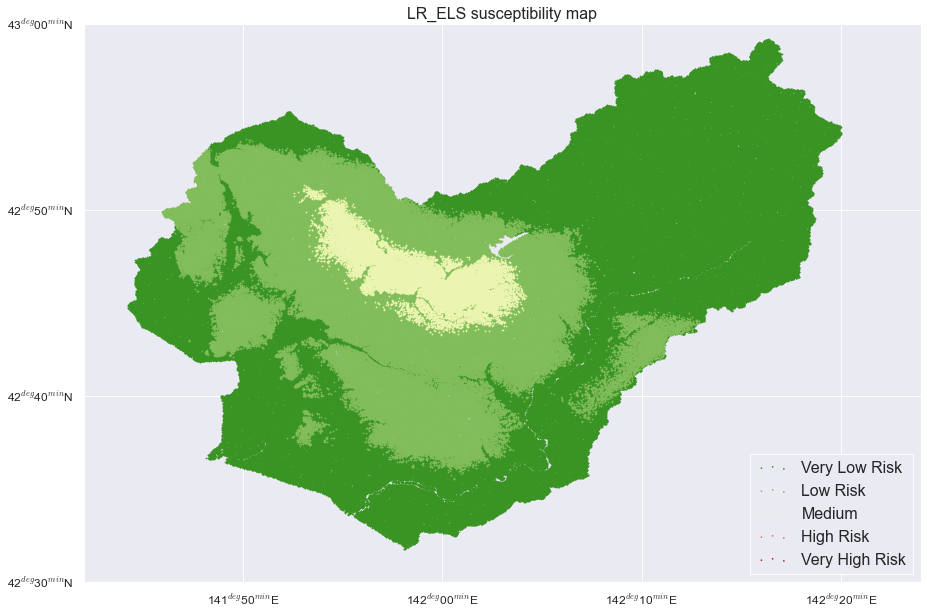

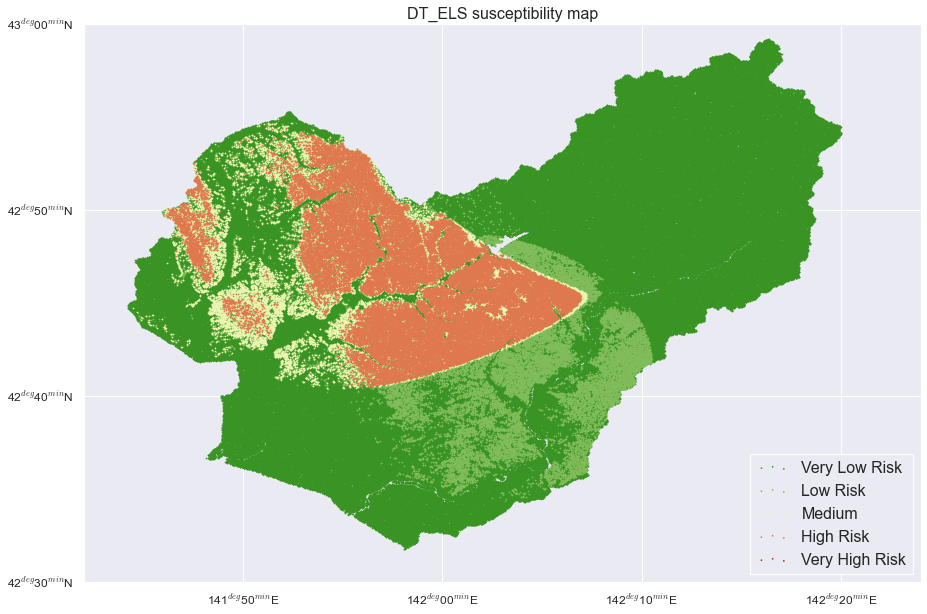

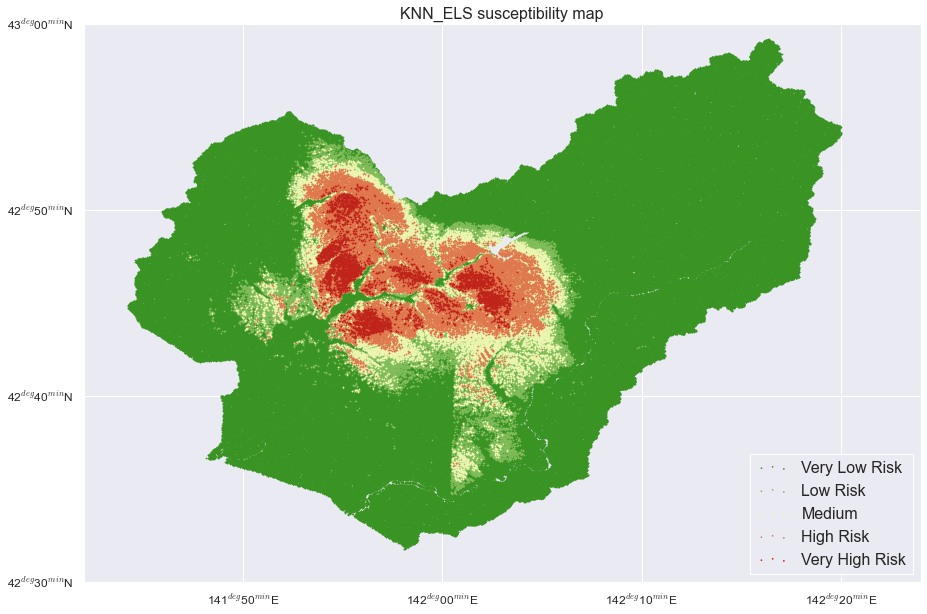

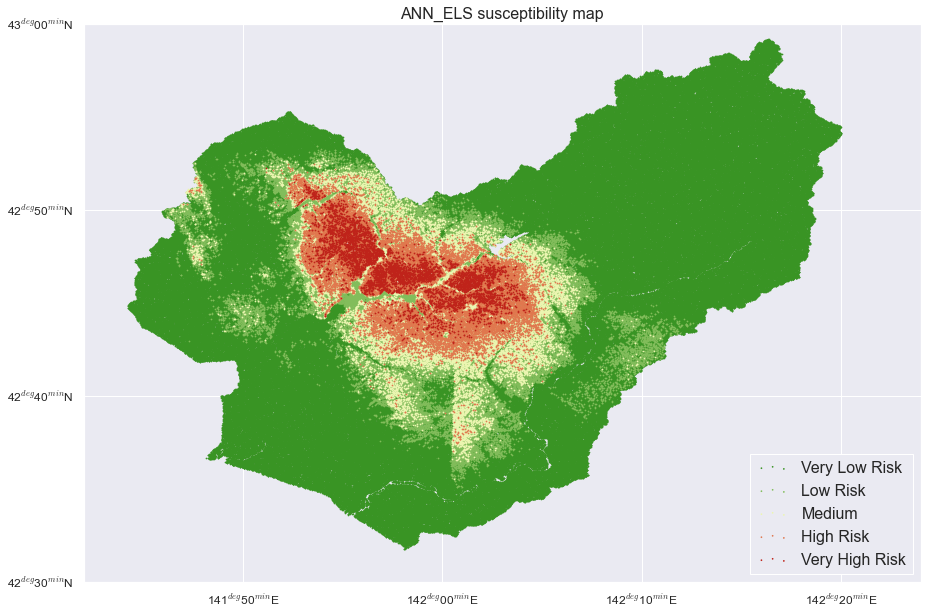

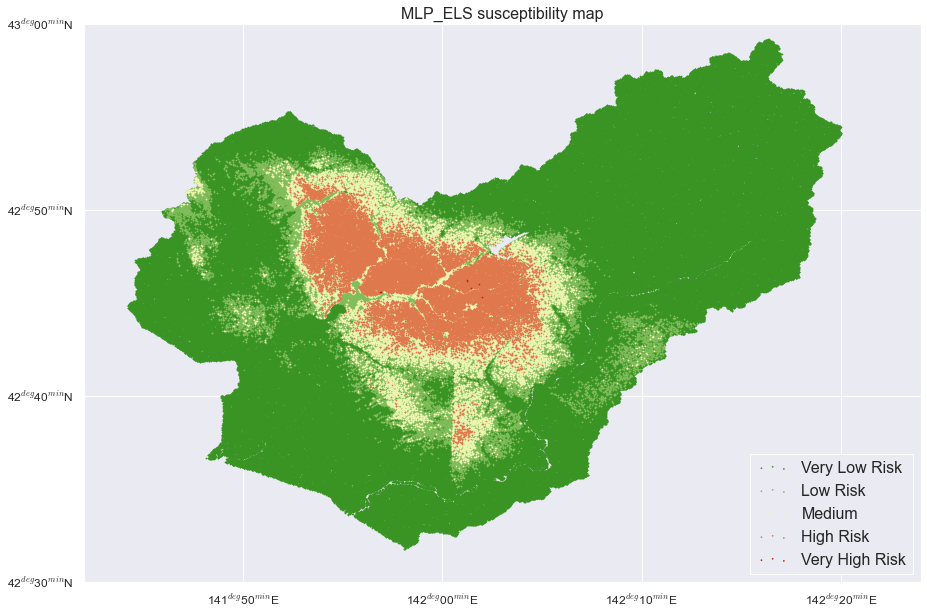

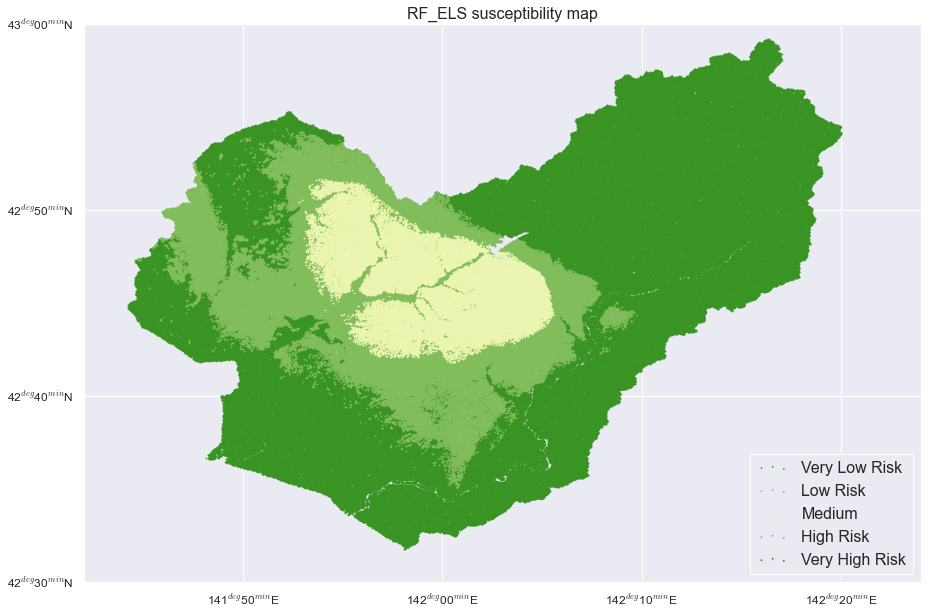

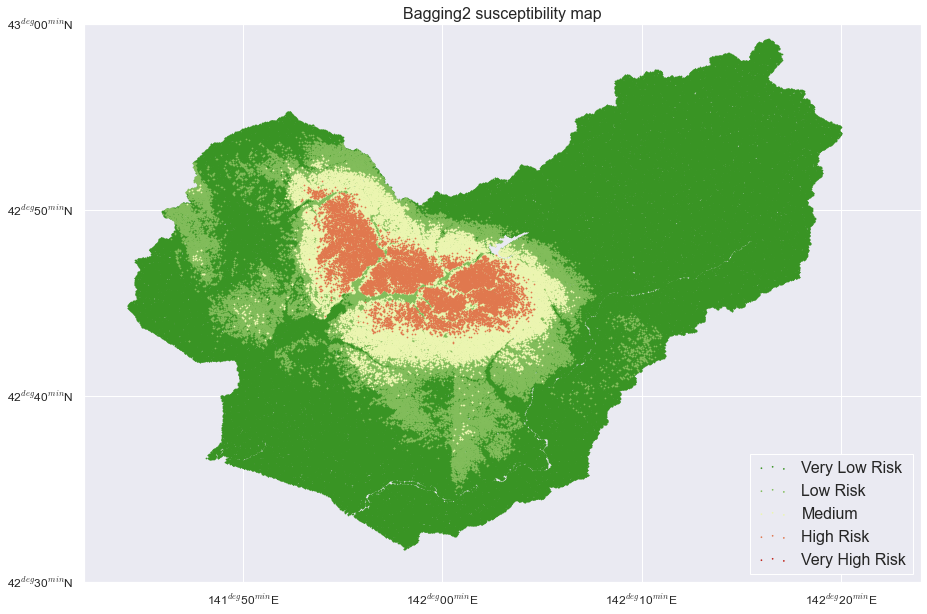

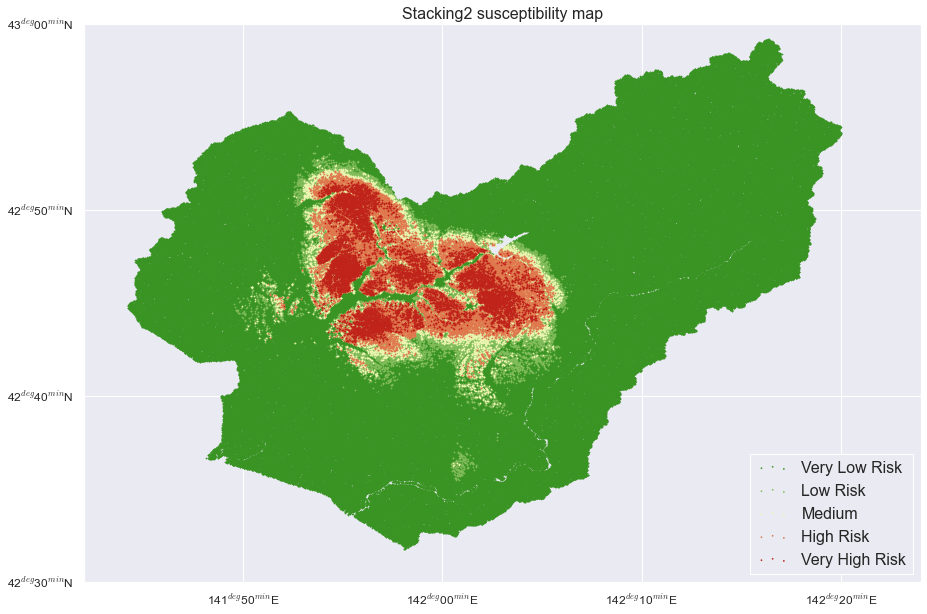

In [97]:
Labelvalues = ['Very Low Risk','Low Risk','Medium','High Risk','Very High Risk']
ColorLabel = ['#399424','#82BD5B','#ECF6B1','#E0784E','#BF231A']
bins = [-0.1,0.2,0.4,0.6,0.8,1.0]
TargetModel2 = ['LR_ELS','DT_ELS','KNN_ELS','ANN_ELS','MLP_ELS','RF_ELS','Bagging2','Stacking2']

for i in TargetModel2:
    ModelResult4['ELS_Risk'] = pd.cut(ModelResult4[i],bins,labels=['Very Low Risk','Low Risk',
                                                                      'Medium','High Risk','Very High Risk']) 

    plot_map_point(ModelResult4,Labelvalues,Labelvalues,ColorLabel,var='ELS_Risk',titles = i)
    

In [606]:
def plot_map_point(Data,Labelvalues,Labletext,ColorLabel,var='A1',titles='Susceptibility map'):
    
    plt.figure(figsize=(15,10))
    
    for i in range(len(Labelvalues)):
        temp = Data[Data[var]==Labelvalues[i]]
        plt.scatter(temp['X'],temp['Y'],marker='o',color =ColorLabel[i] ,label=Labletext[i],s=0.5)
    
    plt.xticks(np.linspace(141.5,142.5,7),
           ['141$^{deg}$30$^{min}$E','141$^{deg}$40$^{min}$E','141$^{deg}$50$^{min}$E',
            '142$^{deg}$00$^{min}$E','142$^{deg}$10$^{min}$E','142$^{deg}$20$^{min}$E','142$^{deg}$30$^{min}$E'],fontsize=12);
    plt.xlim(141.7,142.4)

    plt.ylim(42.5,43.0)
    plt.yticks(np.linspace(42.5,43.0,4),
           ['42$^{deg}$30$^{min}$N','42$^{deg}$40$^{min}$N','42$^{deg}$50$^{min}$N','43$^{deg}$00$^{min}$N'],fontsize=12);

    plt.legend(loc = 'lower right',fontsize=16);
    plt.title(titles+' susceptibility map',fontsize=16)
    plt.show()